In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Read Login json

In [2]:
'''Logins json'''
with open ("logins.json") as f:
    logins=json.load(f) 
loginsDf=pd.DataFrame.from_dict(logins)
print(loginsDf.shape)
loginsDf.head(3)
loginsDf.to_csv("logins.csv")

(93142, 1)


In [3]:
'''ultimate_data_challenge json'''
import json
with open ("ultimate_data_challenge.json") as f:
    data=json.load(f) 
df=pd.DataFrame.from_dict(data)
print(df.shape)
df.head(3)    

(50000, 12)


avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7        1.1   
1      8.26                   5.0                   5.0        1.0   
2      0.77                   5.0                   4.3        1.0   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False         50.0  
2                       3                False        100.0

## Aggregate logins

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
df = spark.read.csv("logins.csv", header=True,inferSchema=True)
df.columns

['_c0', 'login_time']

In [6]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- login_time: timestamp (nullable = true)



In [7]:
df.show(5)

+---+-------------------+
|_c0|         login_time|
+---+-------------------+
|  0|1970-01-01 20:13:18|
|  1|1970-01-01 20:16:10|
|  2|1970-01-01 20:16:37|
|  3|1970-01-01 20:16:36|
|  4|1970-01-01 20:26:21|
+---+-------------------+
only showing top 5 rows



In [8]:
'''Create a Spark Table View'''
df.createOrReplaceTempView("logins")

In [9]:
spark.sql("select * from logins").show(10)

+---+-------------------+
|_c0|         login_time|
+---+-------------------+
|  0|1970-01-01 20:13:18|
|  1|1970-01-01 20:16:10|
|  2|1970-01-01 20:16:37|
|  3|1970-01-01 20:16:36|
|  4|1970-01-01 20:26:21|
|  5|1970-01-01 20:21:41|
|  6|1970-01-01 20:12:16|
|  7|1970-01-01 20:35:47|
|  8|1970-01-01 20:35:38|
|  9|1970-01-01 20:47:52|
+---+-------------------+
only showing top 10 rows



In [10]:
spark.sql("select min(login_time), max(login_time) from logins").show()

+-------------------+-------------------+
|    min(login_time)|    max(login_time)|
+-------------------+-------------------+
|1970-01-01 20:12:16|1970-04-13 18:57:38|
+-------------------+-------------------+



In [11]:
aggTbl=spark.sql('''
select 
timekey2,
count(timekey2) as ts_cnt,
max(login_time) as ts_max
from
(
        (select login_time,
          UNIX_TIMESTAMP(login_time) as timekey1,
          floor(UNIX_TIMESTAMP(login_time)/(15 * 60)) as timekey2
          from logins
          order by login_time) as t1)
group by timekey2
order by timekey2
          
          ''')

In [12]:
df=pd.DataFrame(
    aggTbl.collect(),
    columns=aggTbl.schema.names
            )

print(df.shape)
print(df.head(10))

(9381, 3)
   timekey2  ts_cnt              ts_max
0       112       2 1970-01-01 20:13:18
1       113       6 1970-01-01 20:26:21
2       114       9 1970-01-01 20:43:59
3       115       7 1970-01-01 20:59:59
4       116       1 1970-01-01 21:09:24
5       117       4 1970-01-01 21:29:19
6       119       4 1970-01-01 21:59:40
7       120       9 1970-01-01 22:12:05
8       121       8 1970-01-01 22:25:09
9       122       1 1970-01-01 22:31:32


In [13]:
df["time_max"]=[item.strftime("%H:%M:%S") for item in df.ts_max]
df["date_max"]=[item.strftime("%Y-%m-%d") for item in df.ts_max]

## Overall login plots 
Summary: The original dataset collects records of user login from the date 2014/01/01 to 2014/07/01. The following plot shows the counts of logins per 15 mins intervals. As shown, we could oberve that there might be recognized patterns, so that we will take a closer look onto the daily login cycles below.

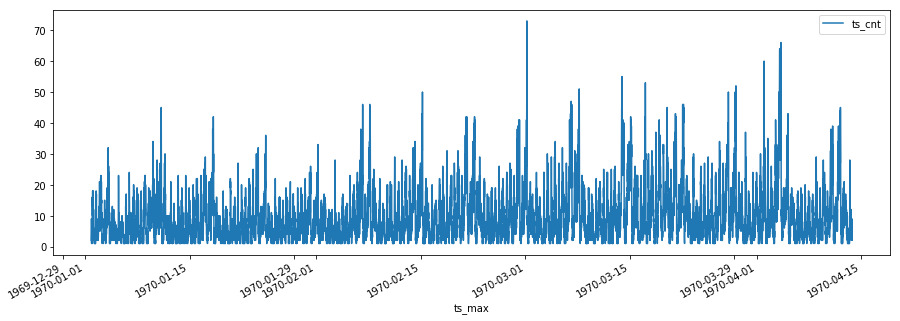

In [14]:
df.plot(x="ts_max", y="ts_cnt", figsize=(15,5))
plt.show()

In [15]:
df.head(10)

timekey2  ts_cnt              ts_max  time_max    date_max
0       112       2 1970-01-01 20:13:18  20:13:18  1970-01-01
1       113       6 1970-01-01 20:26:21  20:26:21  1970-01-01
2       114       9 1970-01-01 20:43:59  20:43:59  1970-01-01
3       115       7 1970-01-01 20:59:59  20:59:59  1970-01-01
4       116       1 1970-01-01 21:09:24  21:09:24  1970-01-01
5       117       4 1970-01-01 21:29:19  21:29:19  1970-01-01
6       119       4 1970-01-01 21:59:40  21:59:40  1970-01-01
7       120       9 1970-01-01 22:12:05  22:12:05  1970-01-01
8       121       8 1970-01-01 22:25:09  22:25:09  1970-01-01
9       122       1 1970-01-01 22:31:32  22:31:32  1970-01-01

### Login count per day
This plot shows the ranking of login in daily basis. As we can see, the maximum number of logins hit about 1800 times on 1970/04/04; The least number of logins is only about 100 times on 1970/01/01. The login frequency varies quite a lot during this half year period. 

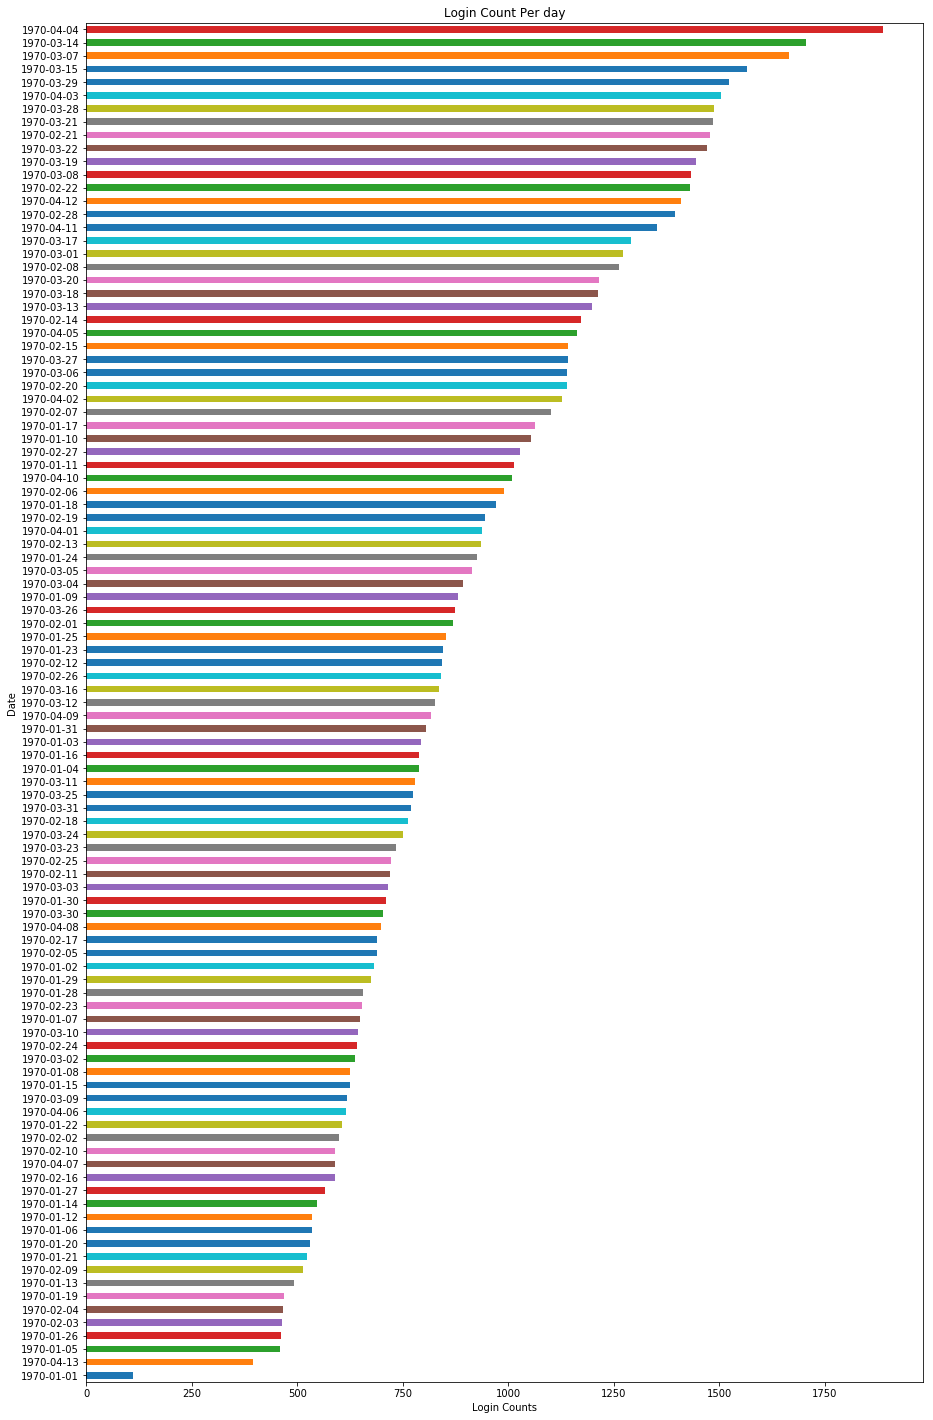

In [22]:
df1=df.groupby(["date_max"], as_index=False).sum()
df1=df1.sort_values(by="ts_cnt")
df1.plot.barh(y="ts_cnt",x="date_max", figsize=(15,25), legend=False)
plt.title("Login Count Per day")
plt.ylabel("Date")
plt.xlabel("Login Counts")
plt.xticks(fontsize=10)
plt.show()

### Login Curve in Daily basis
As shown below, the login frequecy varies during the day. However, there is particular forms are identified, e.g. High peak / traffic of login happens between 10am-2pm and 10pm-2am periods in most of the days; It usually have low login traffics between 5am-10am. Most of the peak counts are approximately 20, but some of the higher counts hit 20 logins. 

In [25]:
'''Function to plot Daily Login Count '''
def plotLoginCntFunc(df,date):
    df2=df[df["date_max"]== date]
    totalCnt=df2.groupby(["date_max"], as_index=False).sum()["ts_cnt"]
    df2.plot(x="time_max", y="ts_cnt", figsize=(15,5), legend=False)

    i=0
    timeLst=[]
    for item in list(df2.time_max):
        if i%2==1:
            timeLst.append(item)
            i+=1
        else: 
            timeLst.append("")
            i+=1        
    plt.xticks(ticks=np.arange(len(list(df2.time_max))),labels=timeLst,rotation=70)
    plt.title("Date: %s - Total Count: %d"%(date, totalCnt))
    plt.xlabel("Time")
    plt.ylabel("Login Count")
    plt.show()

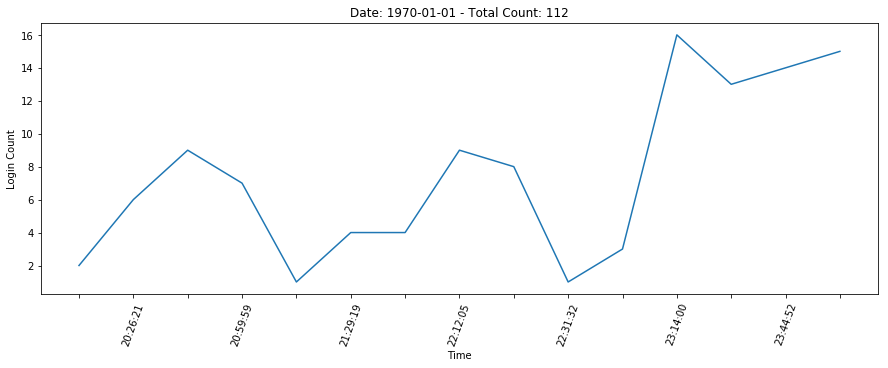

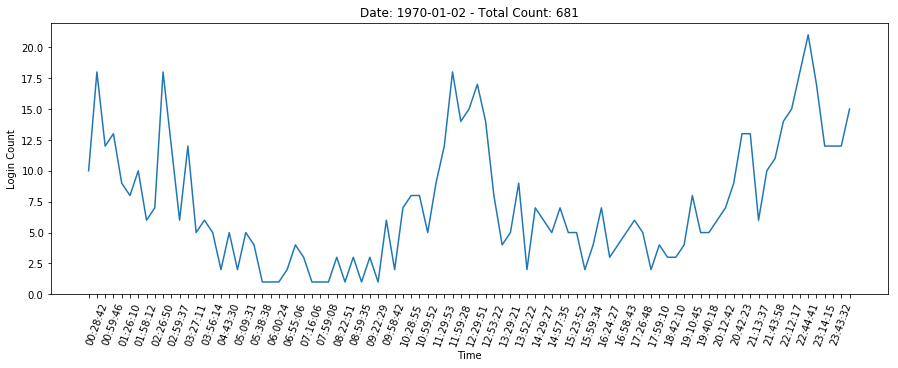

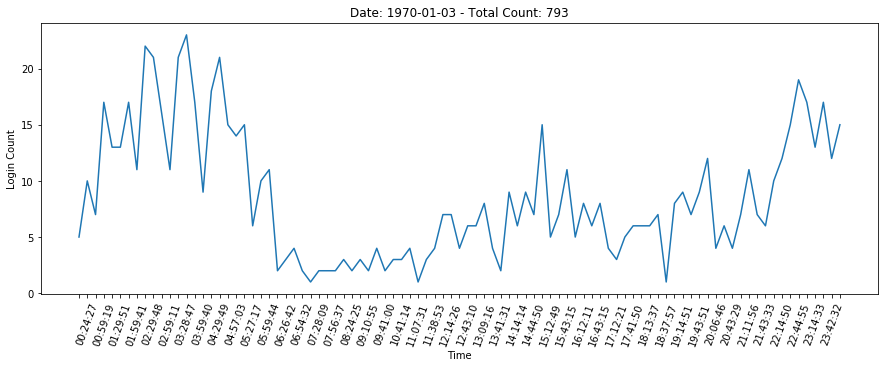

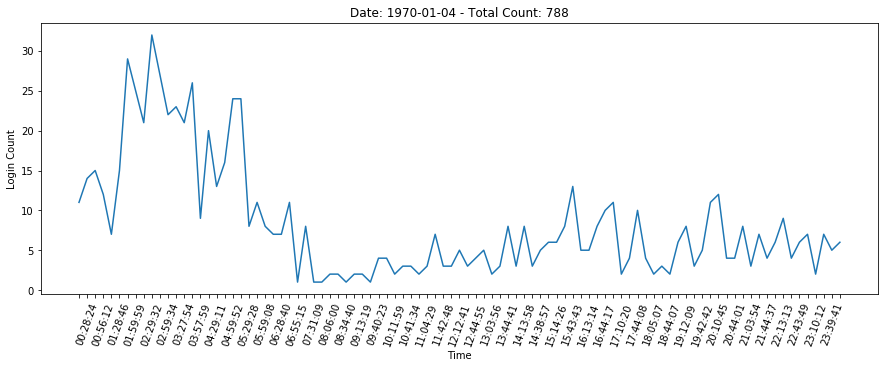

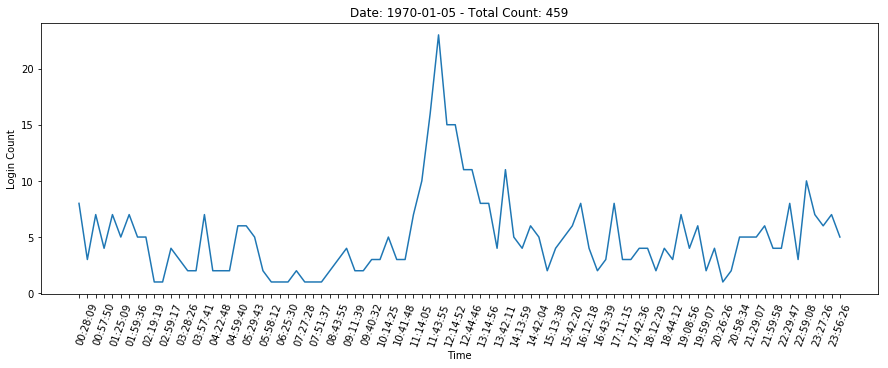

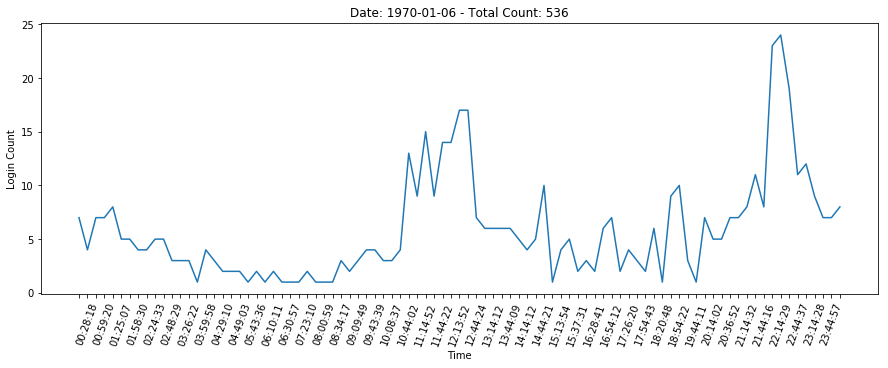

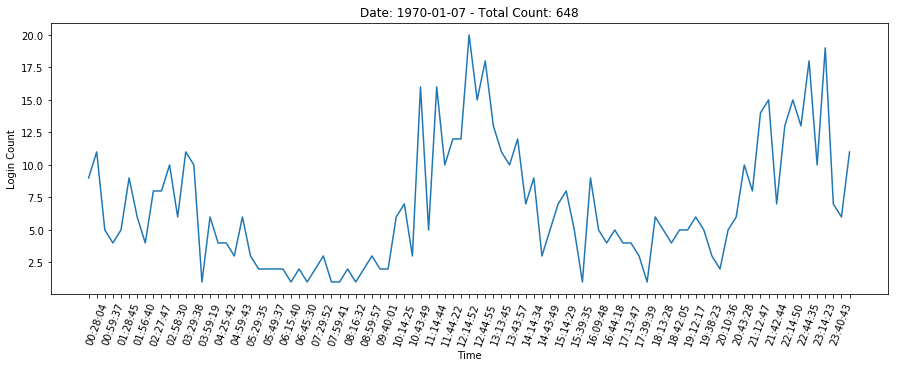

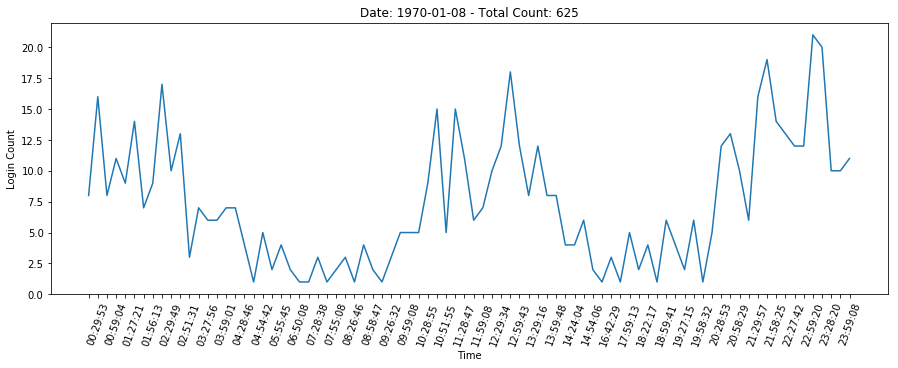

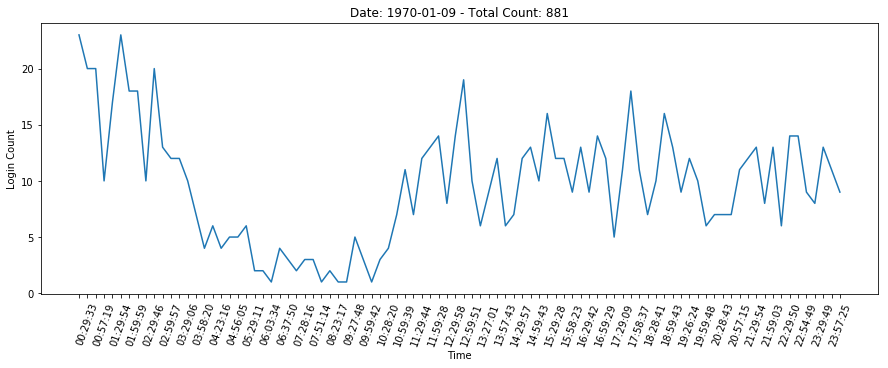

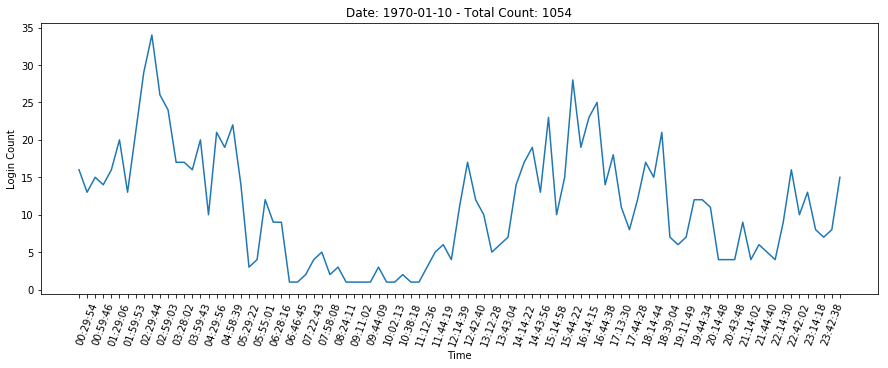

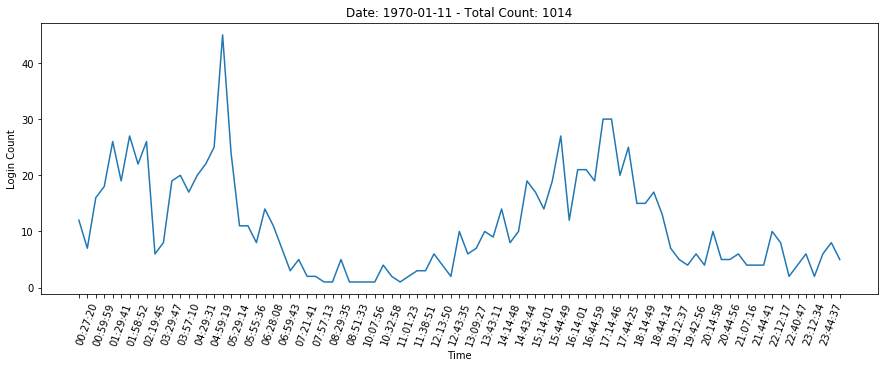

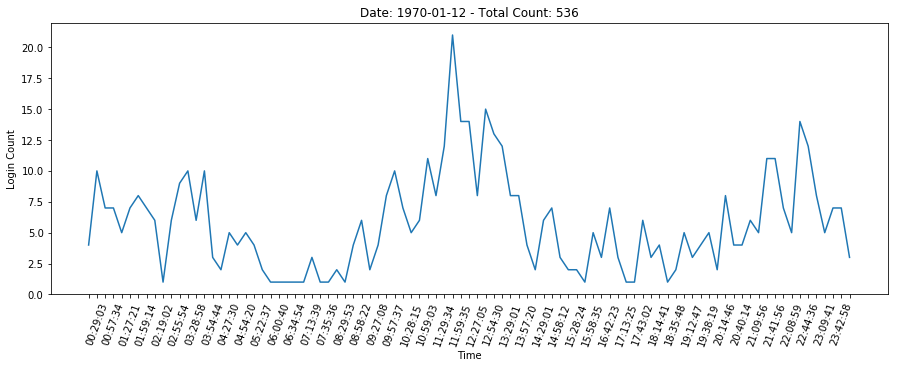

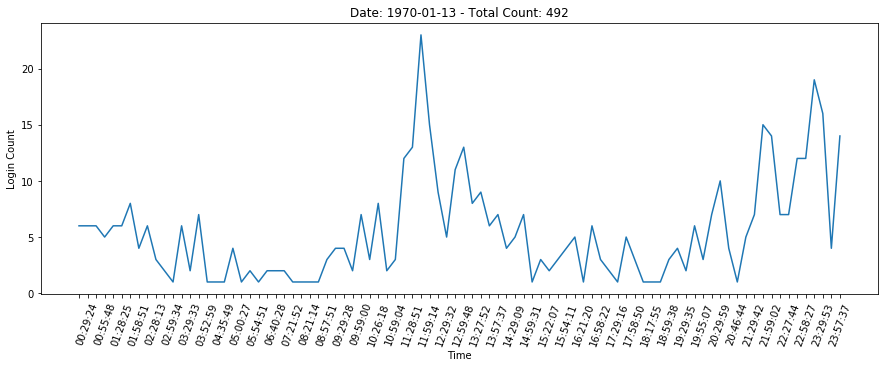

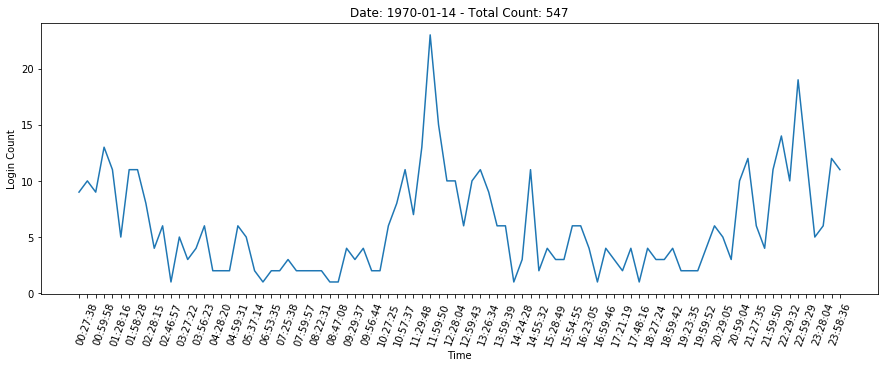

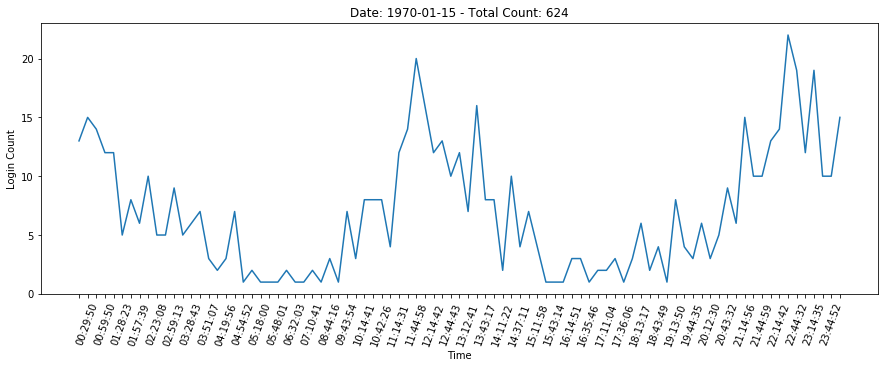

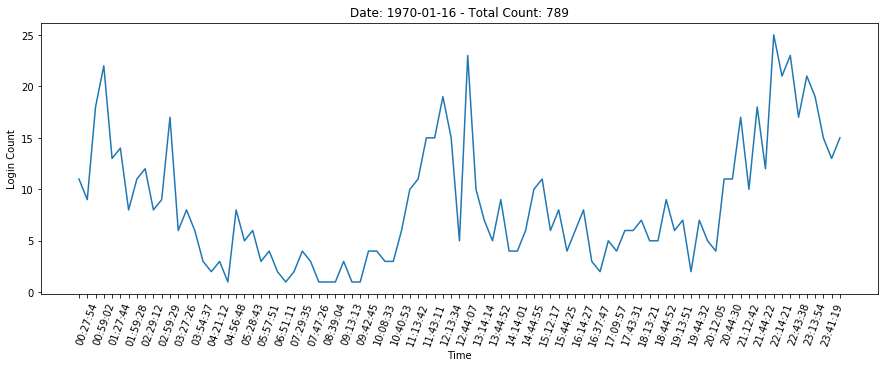

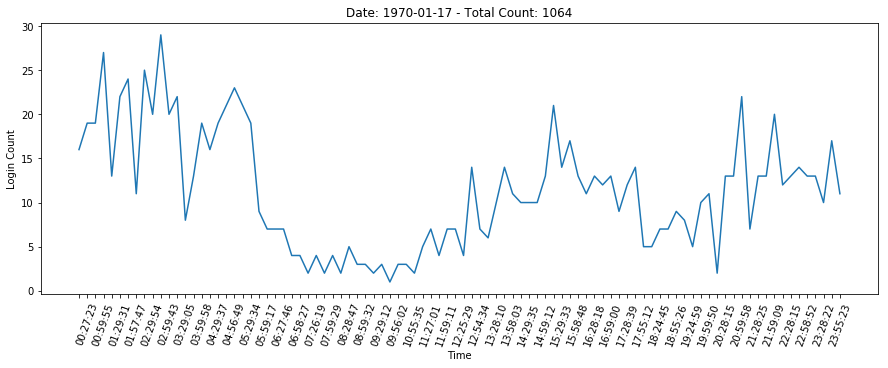

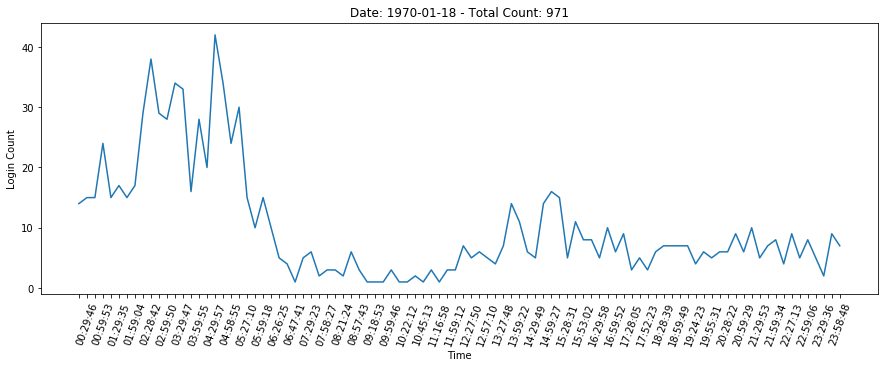

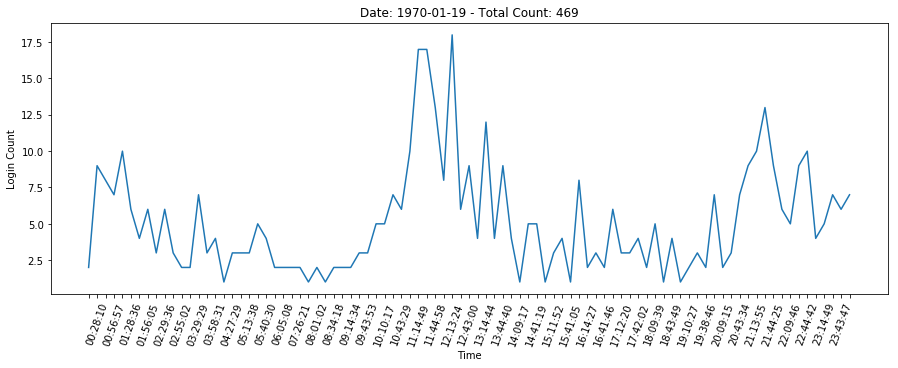

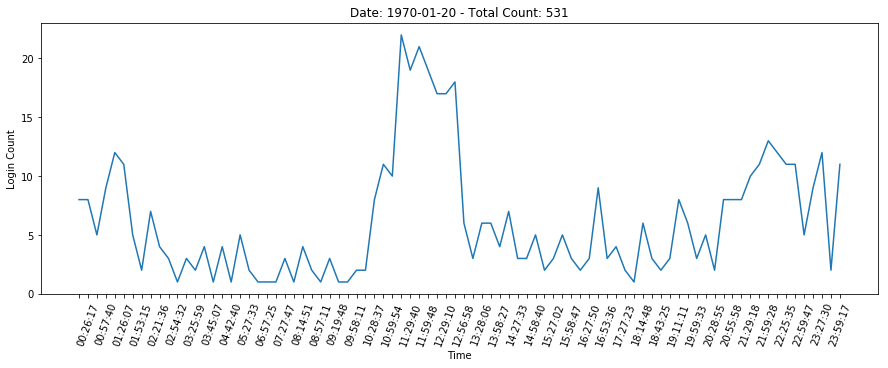

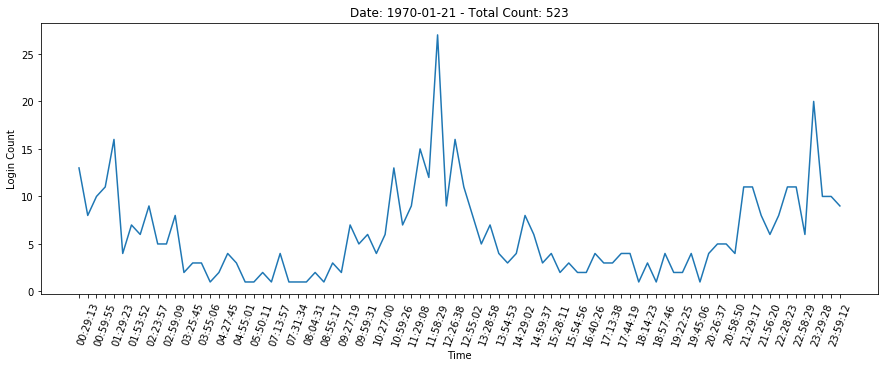

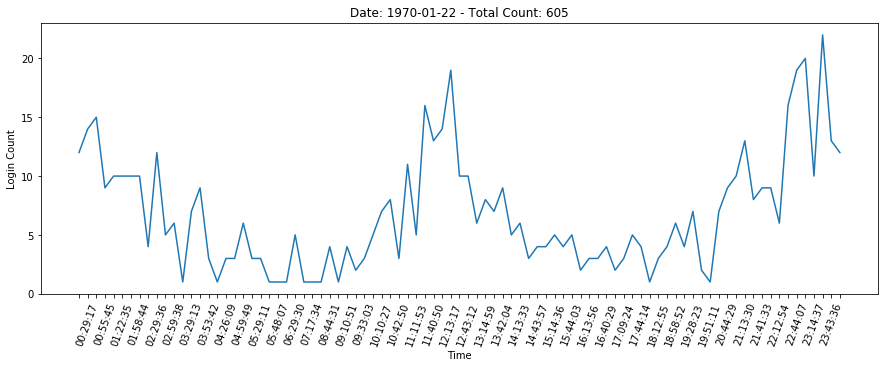

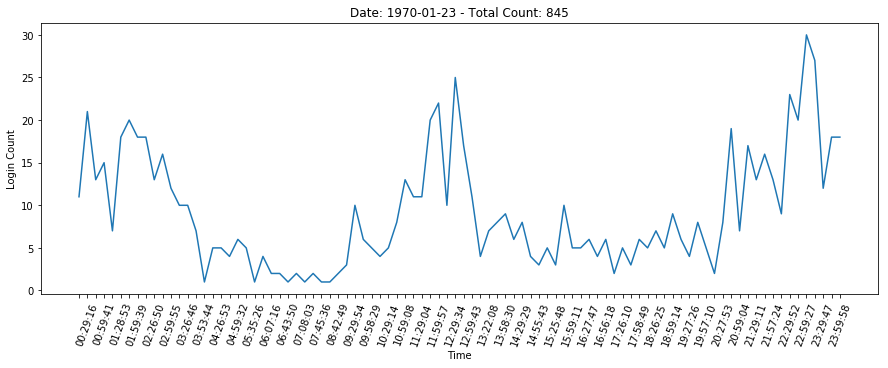

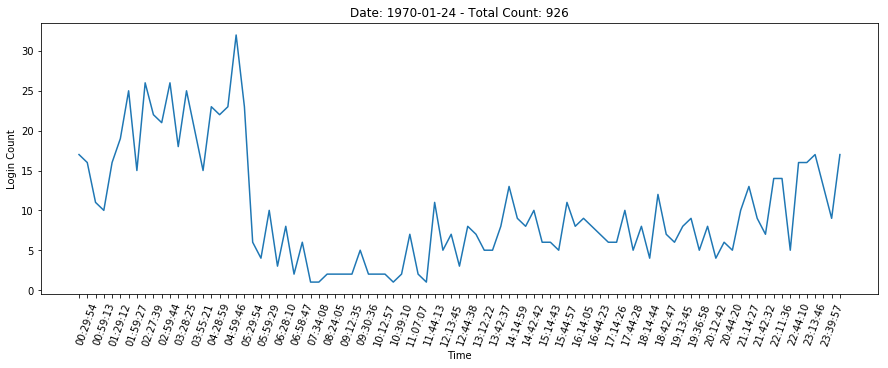

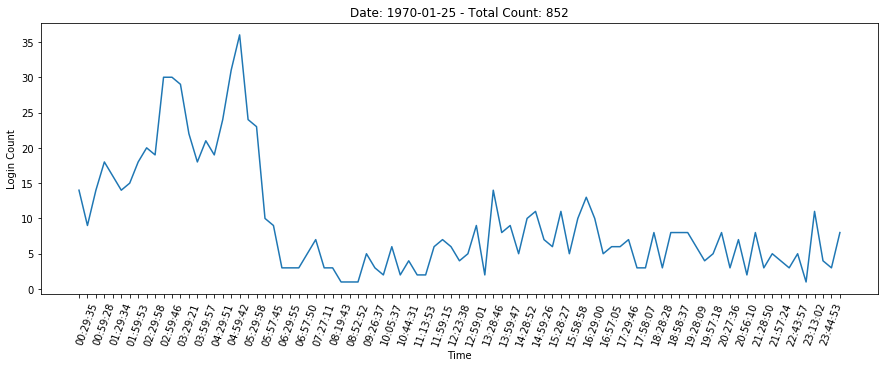

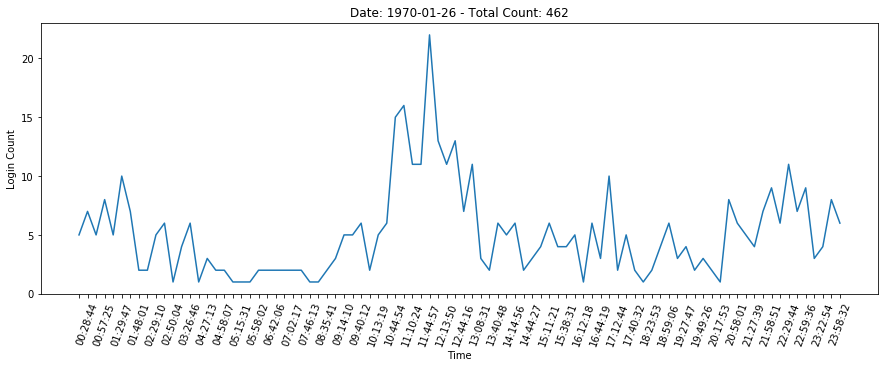

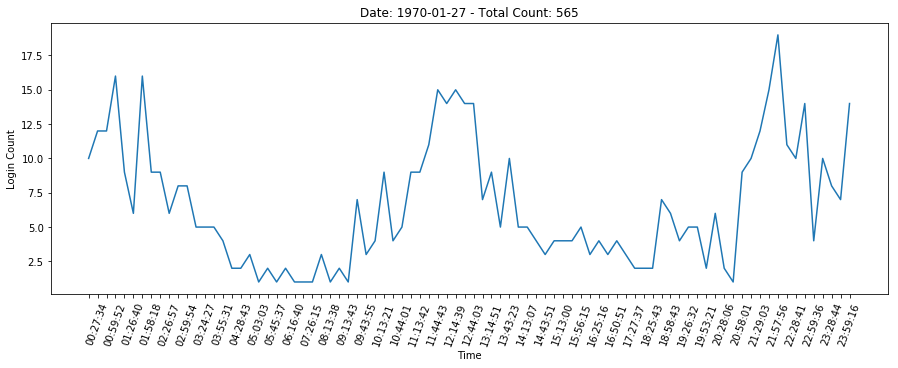

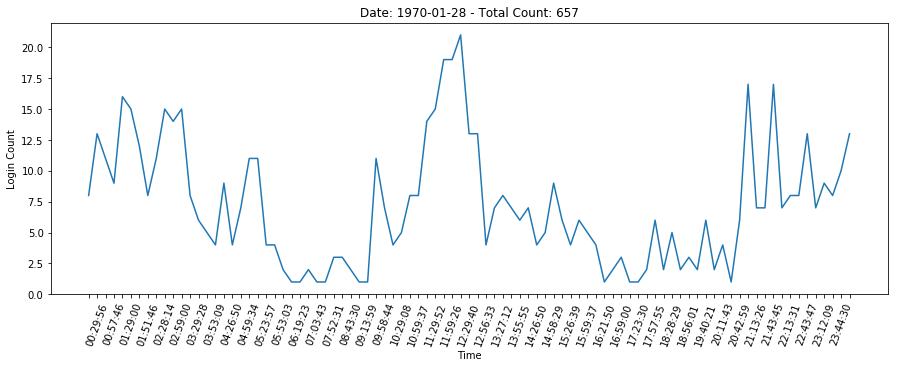

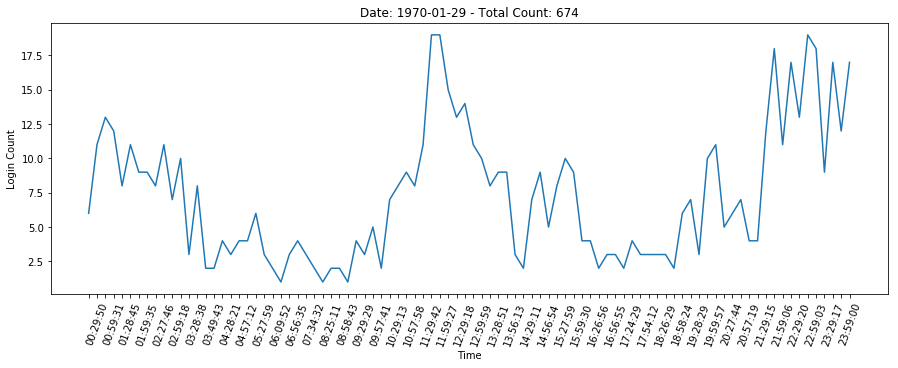

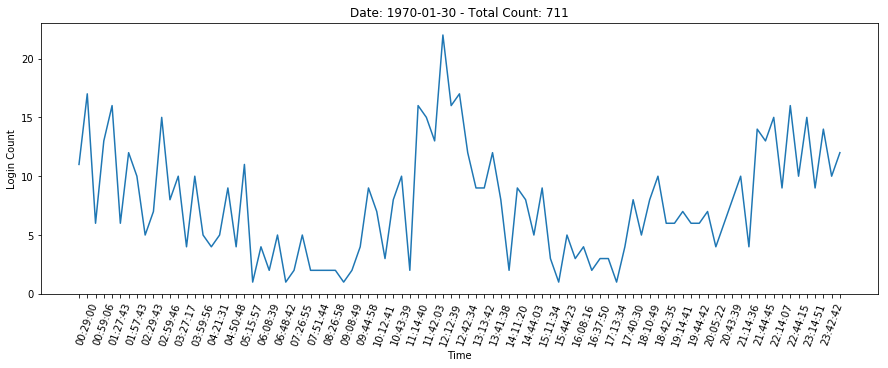

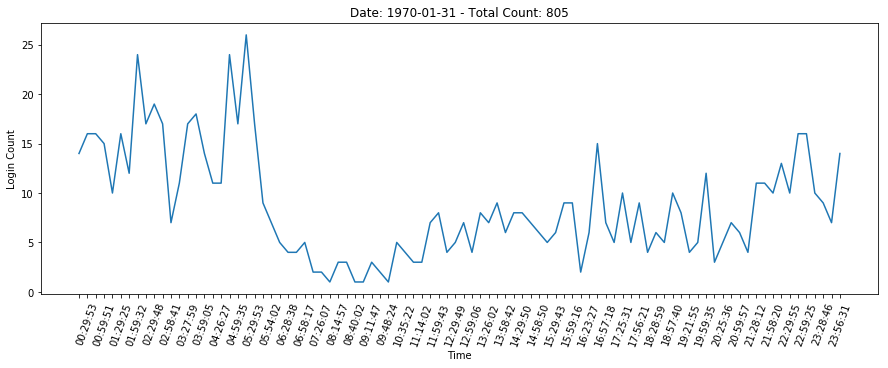

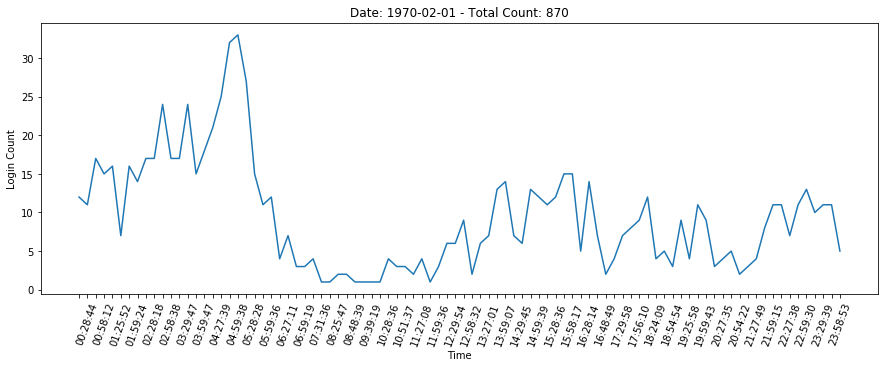

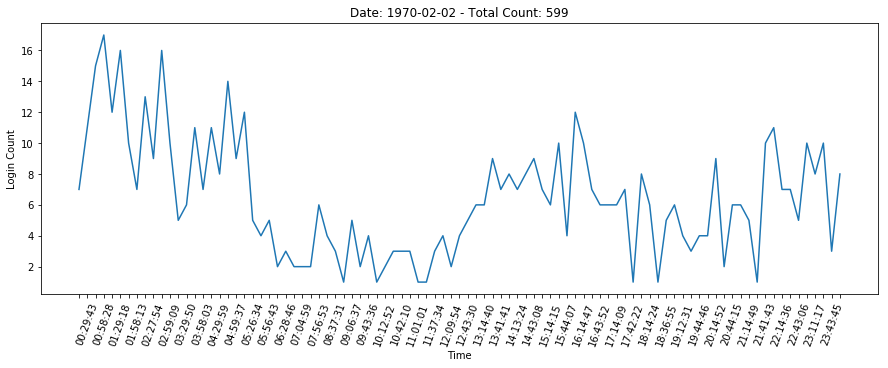

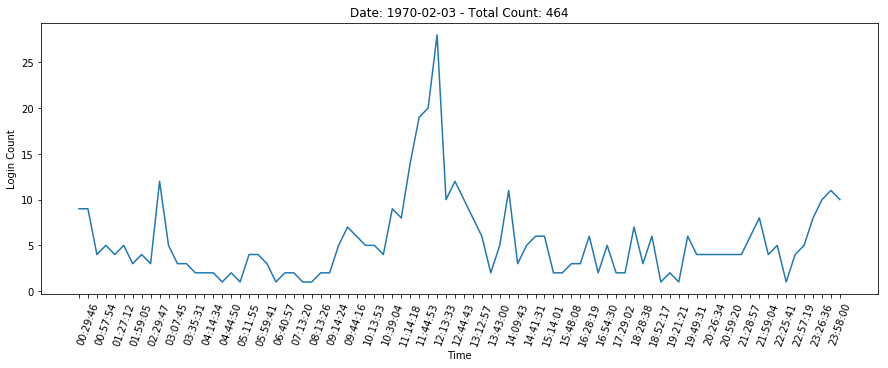

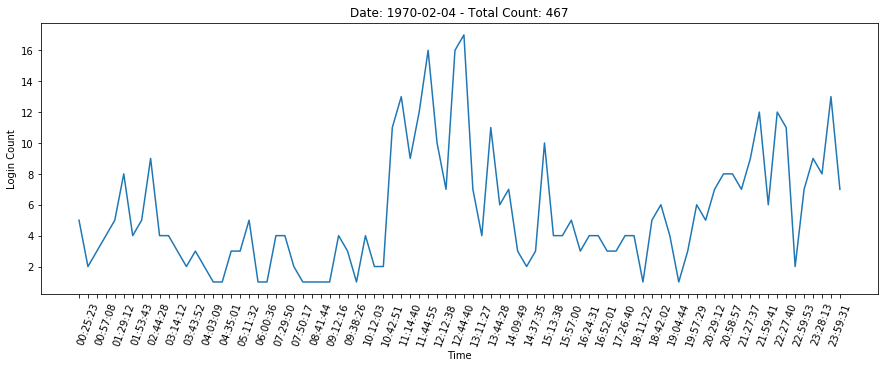

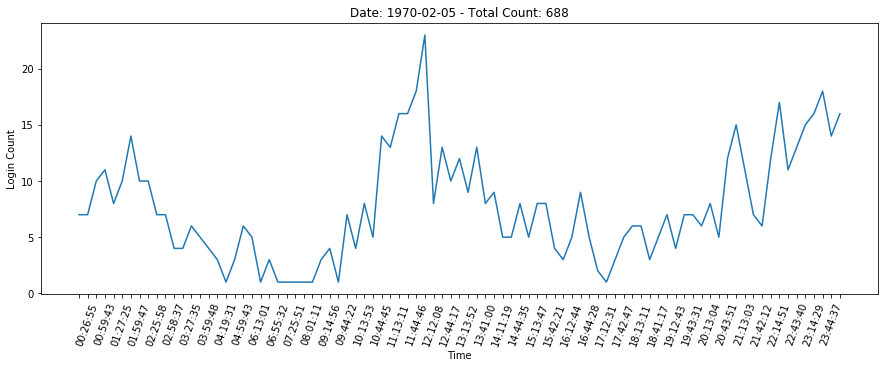

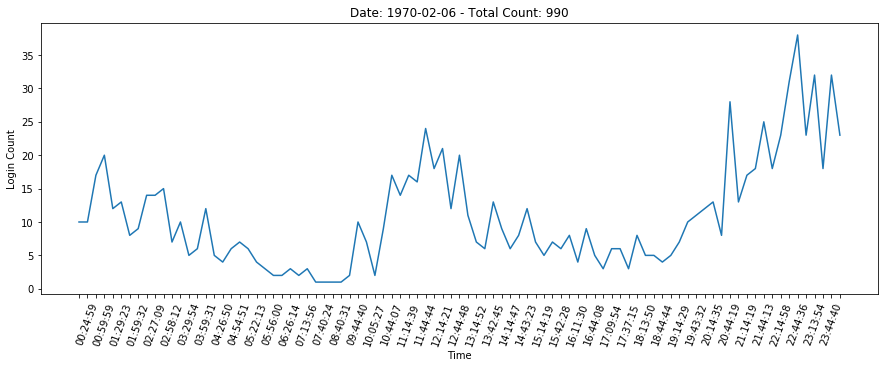

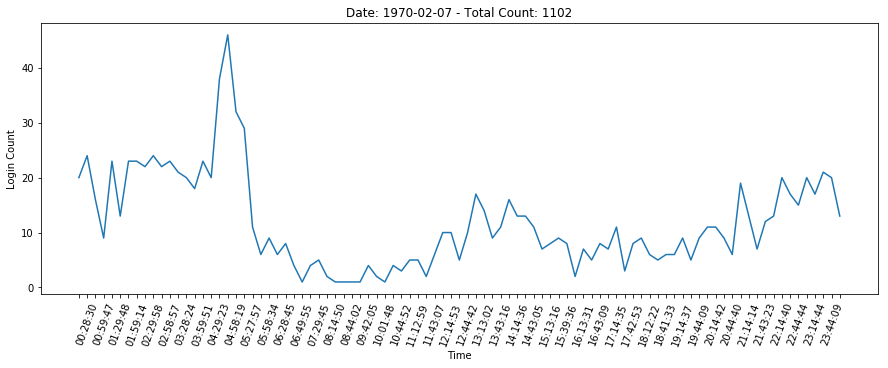

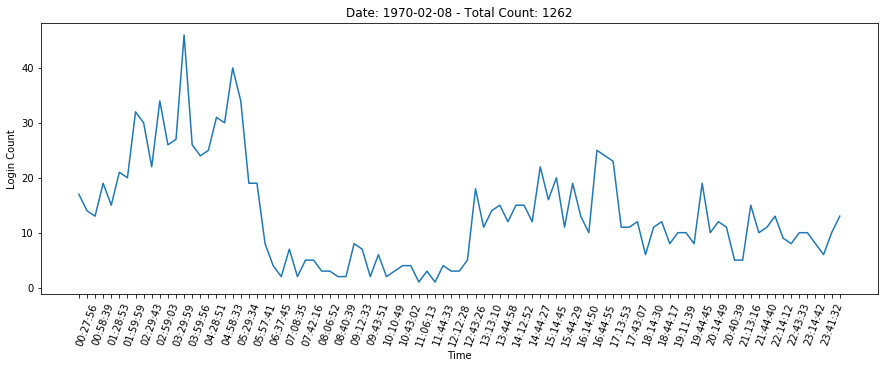

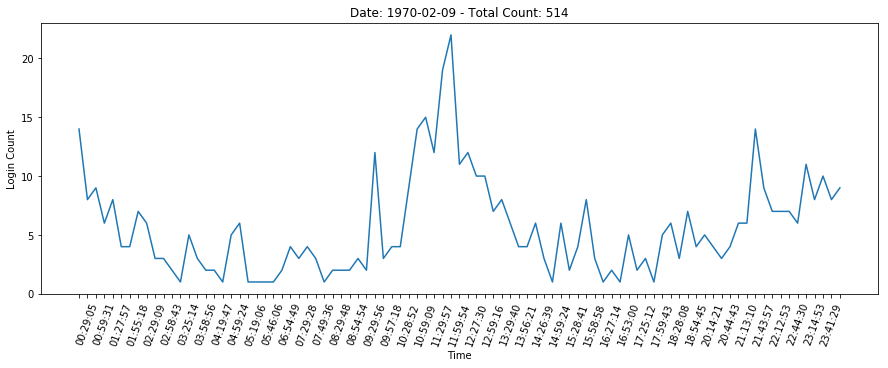

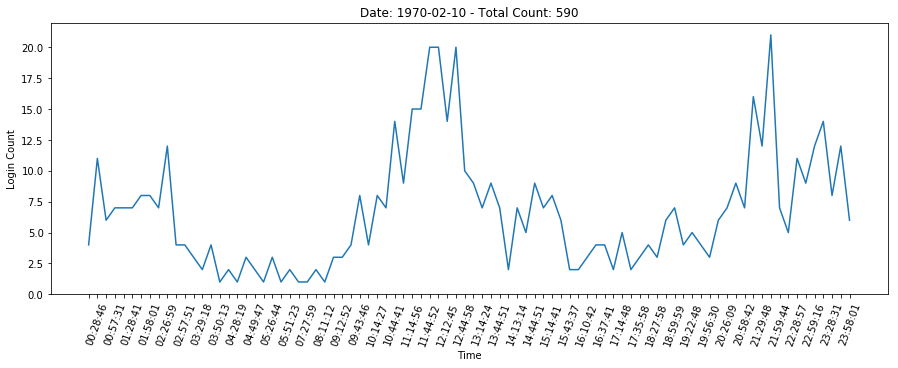

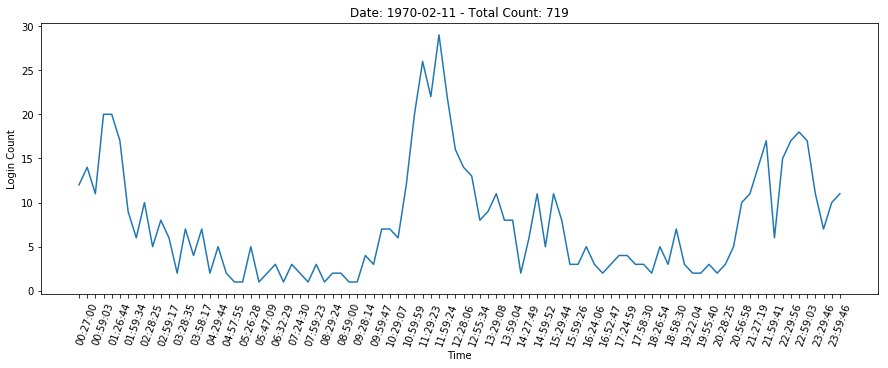

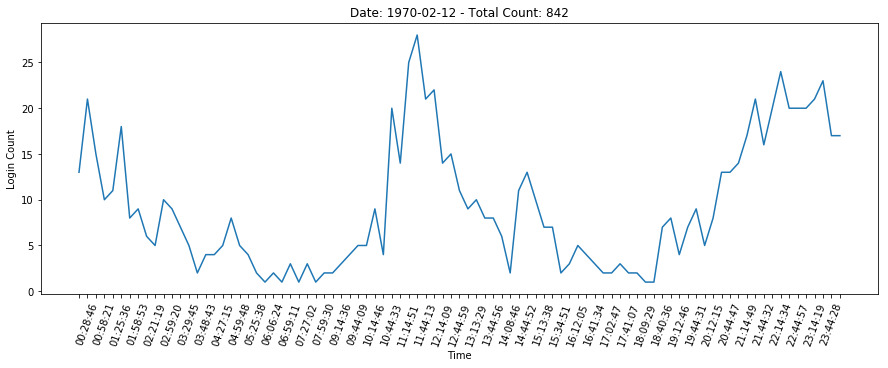

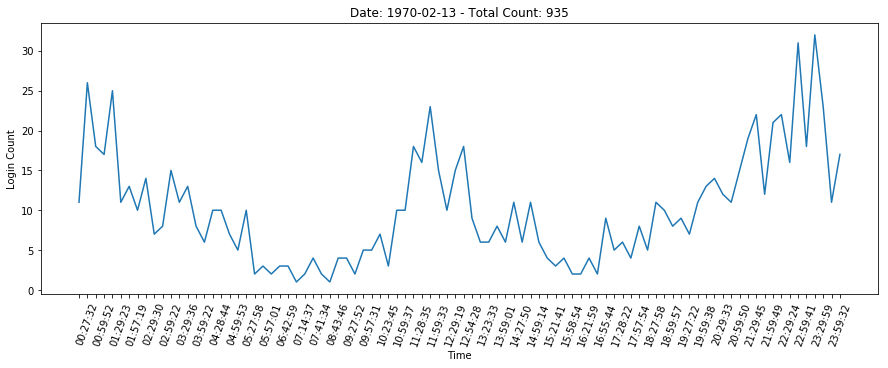

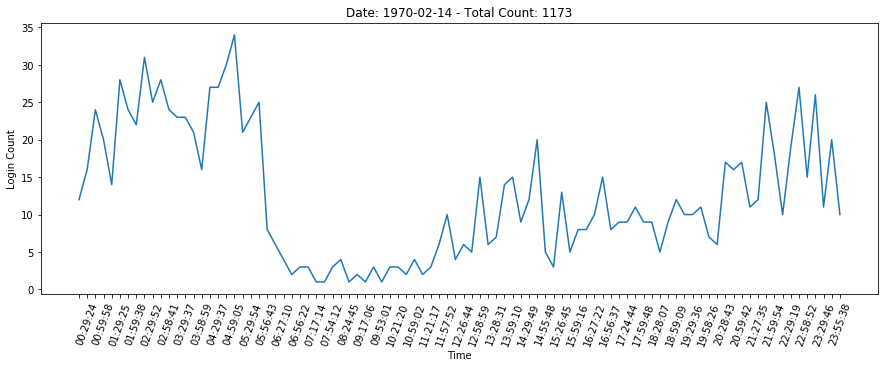

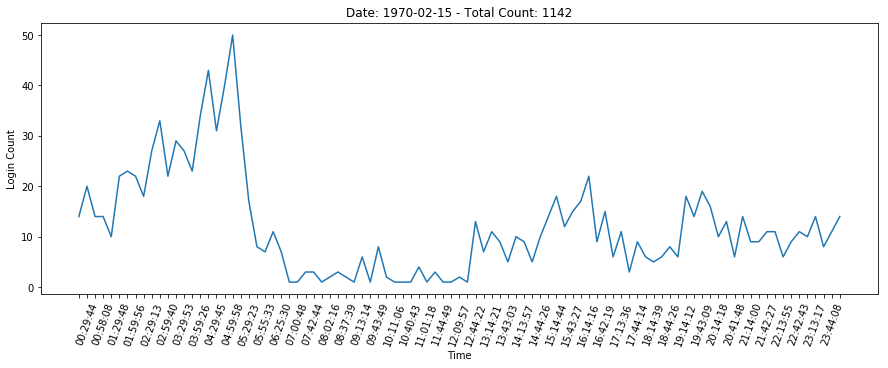

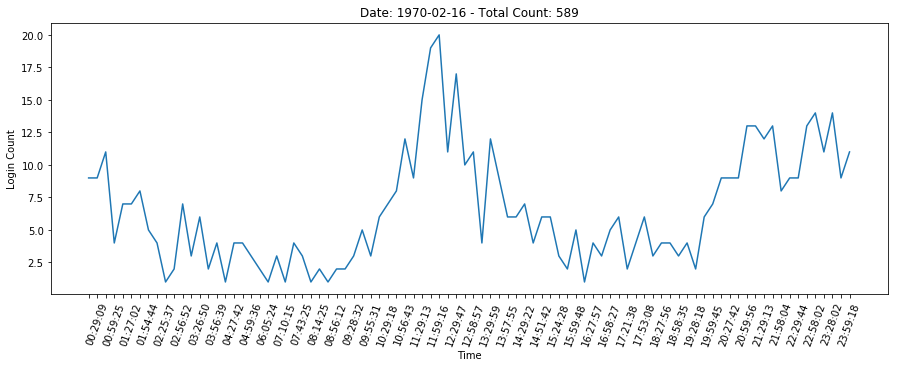

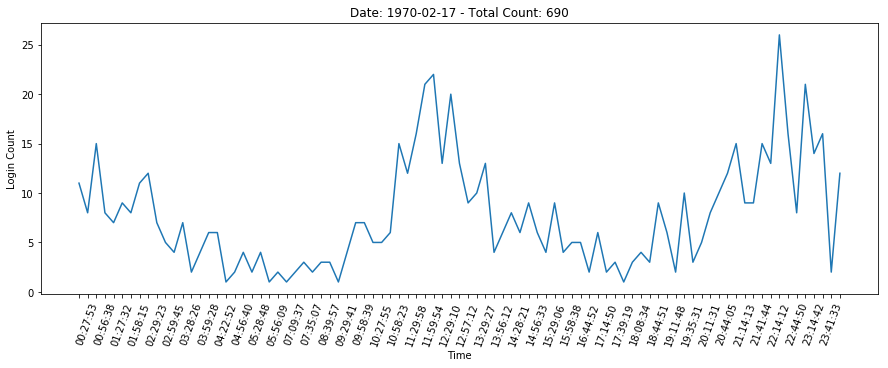

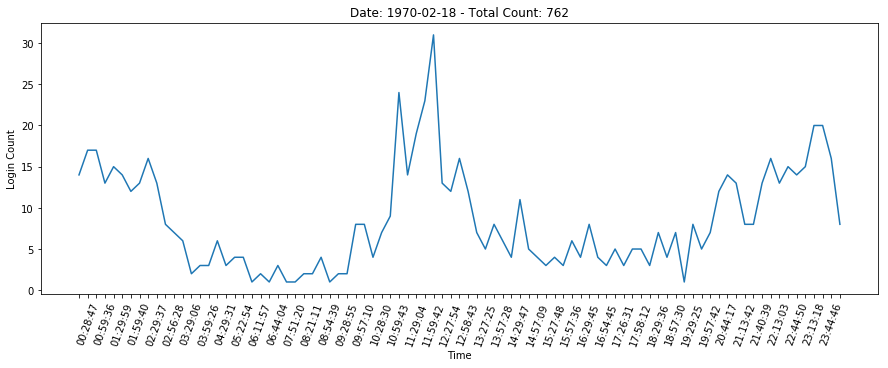

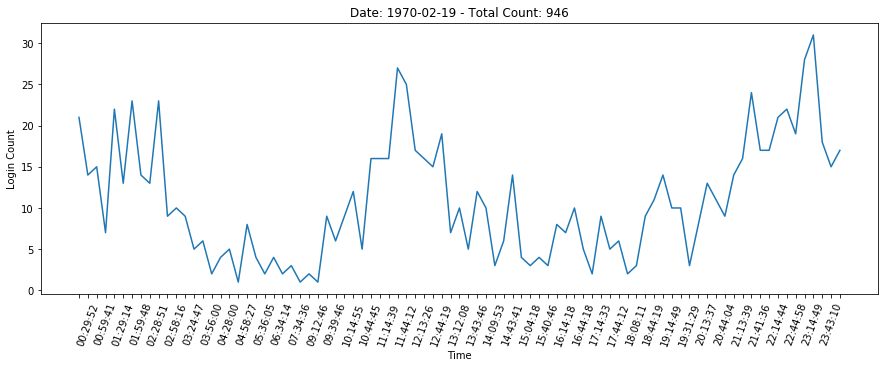

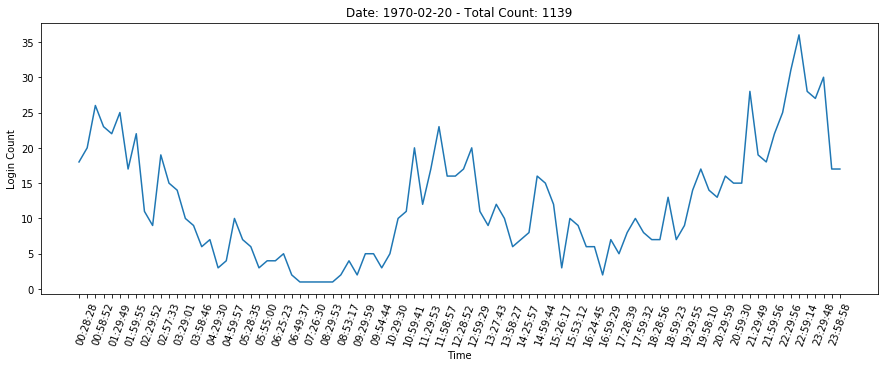

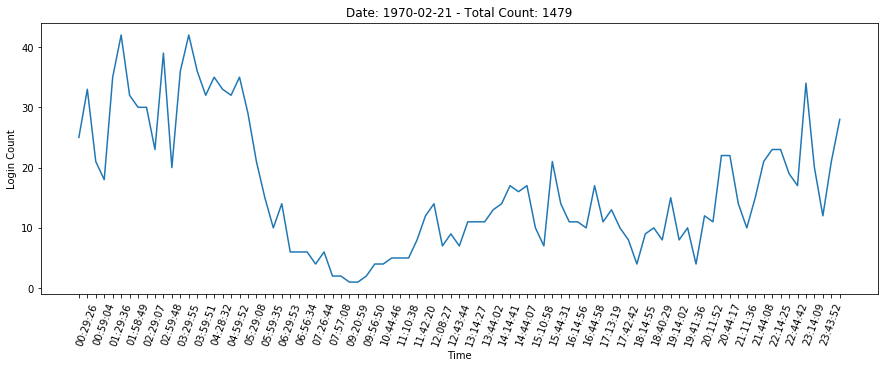

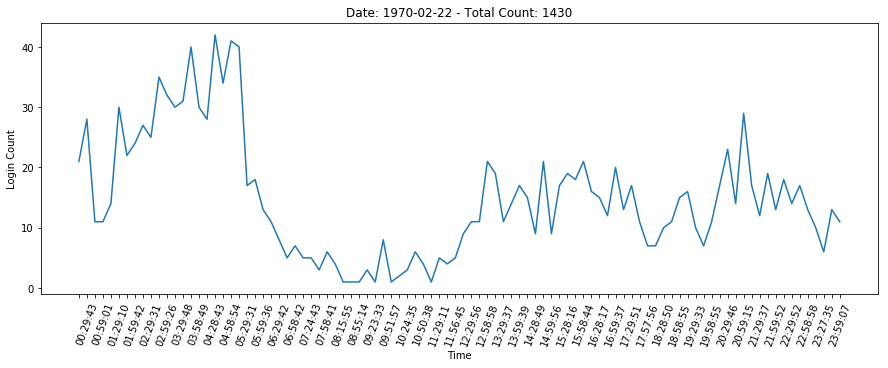

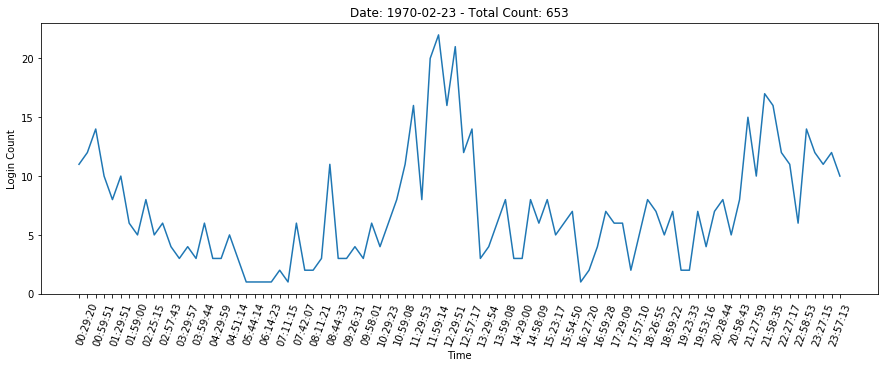

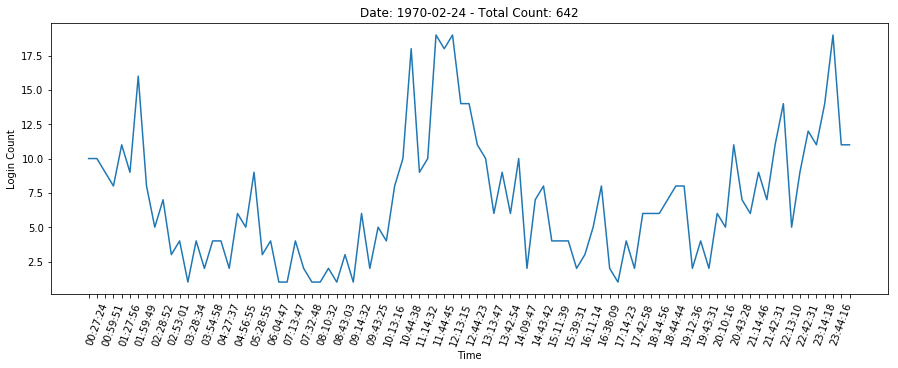

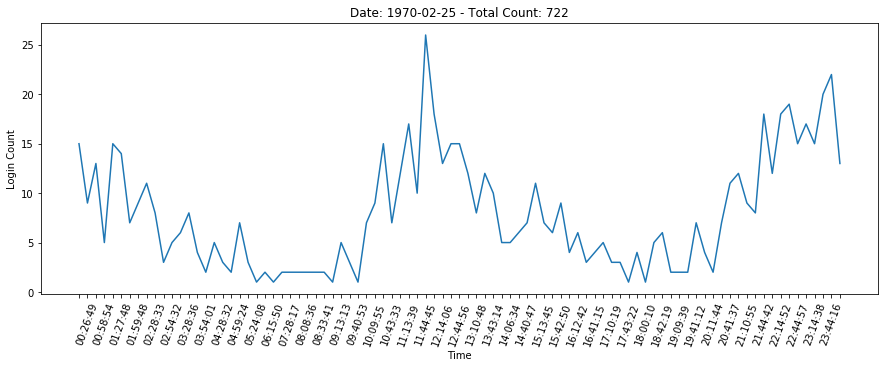

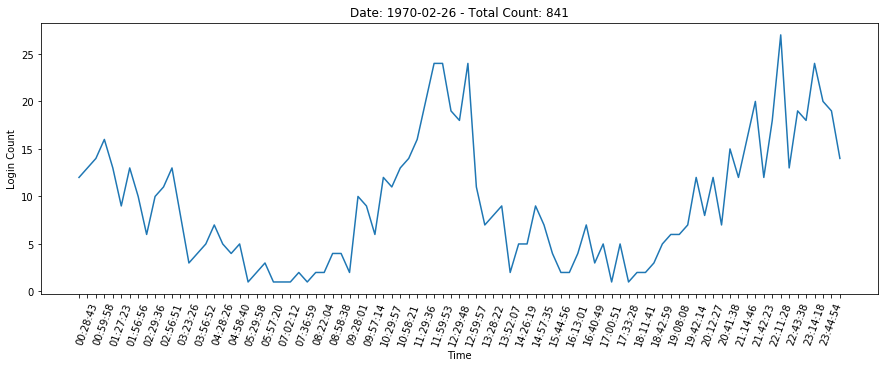

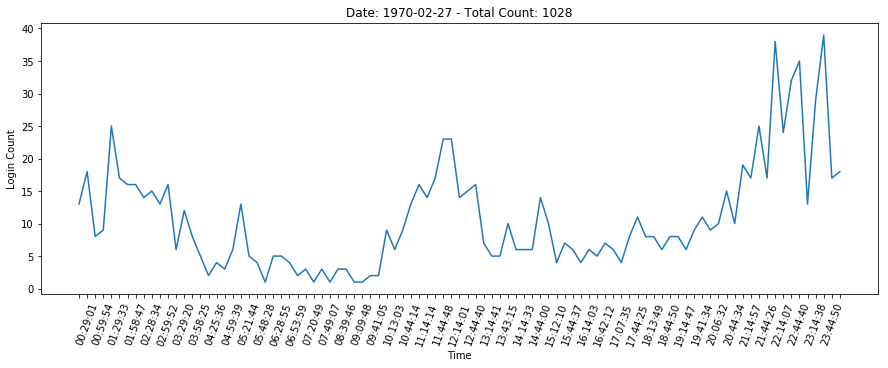

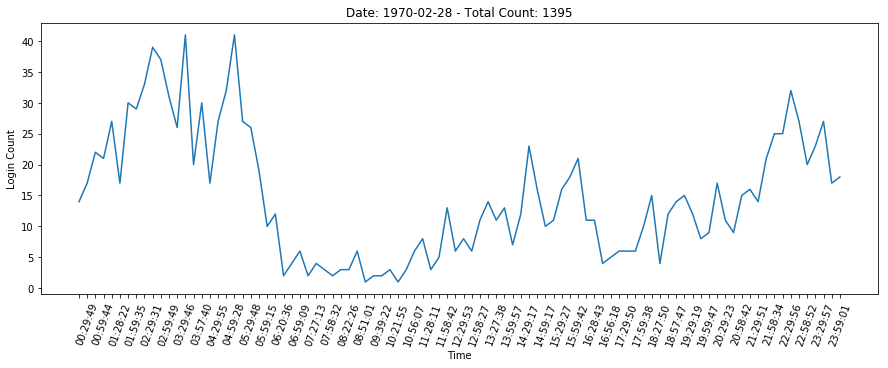

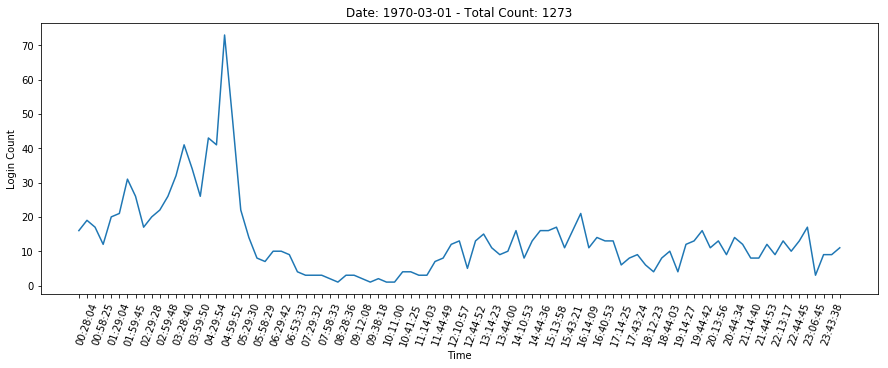

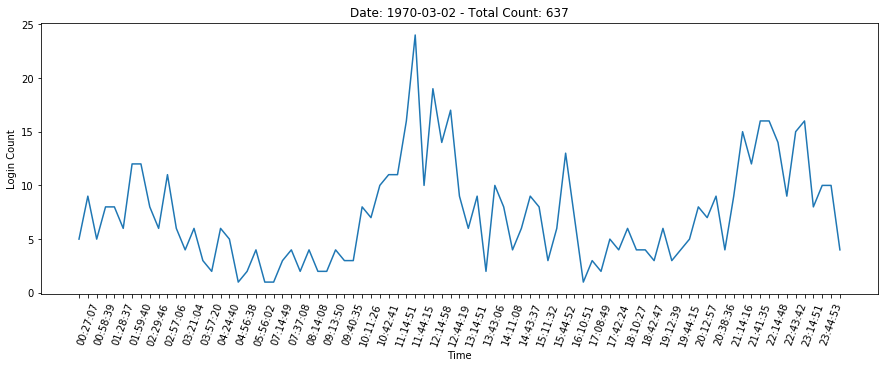

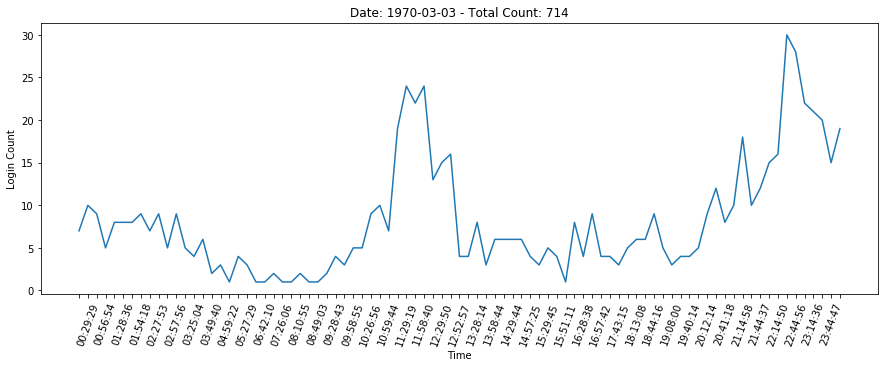

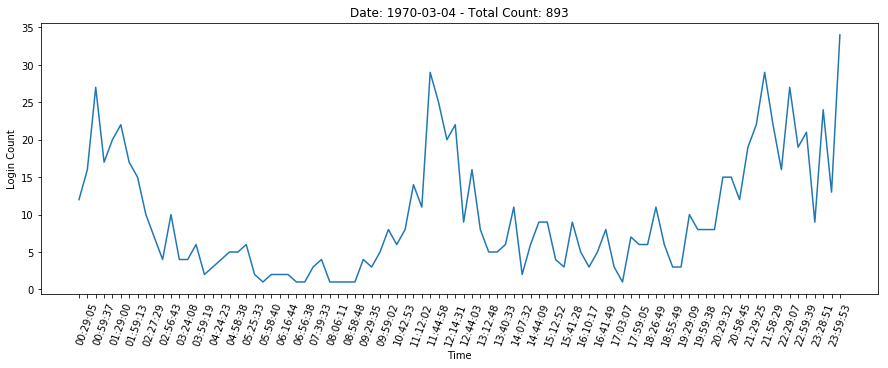

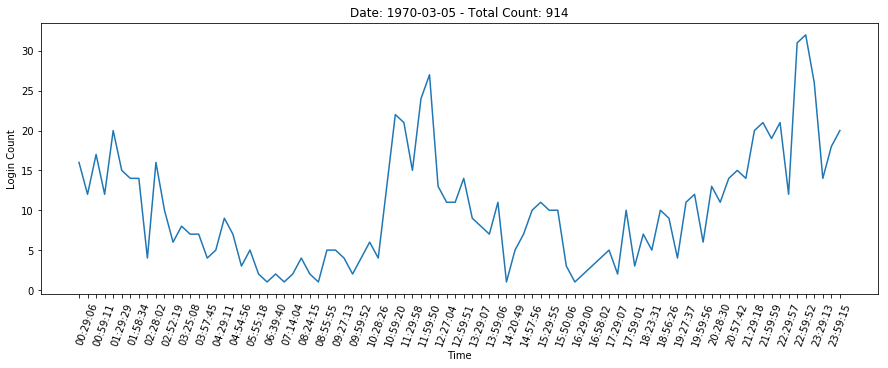

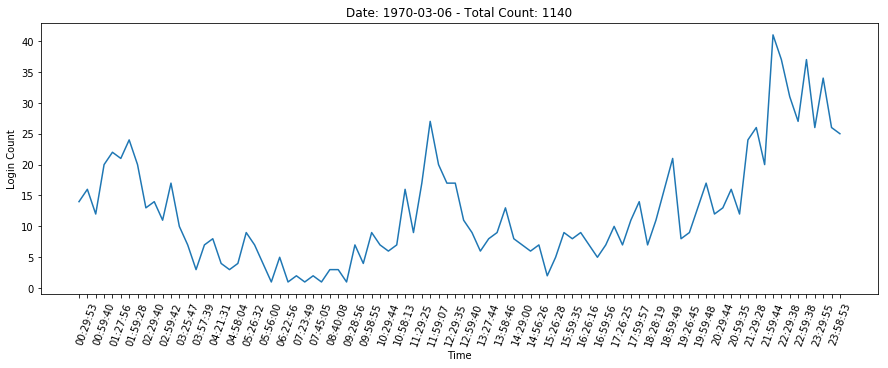

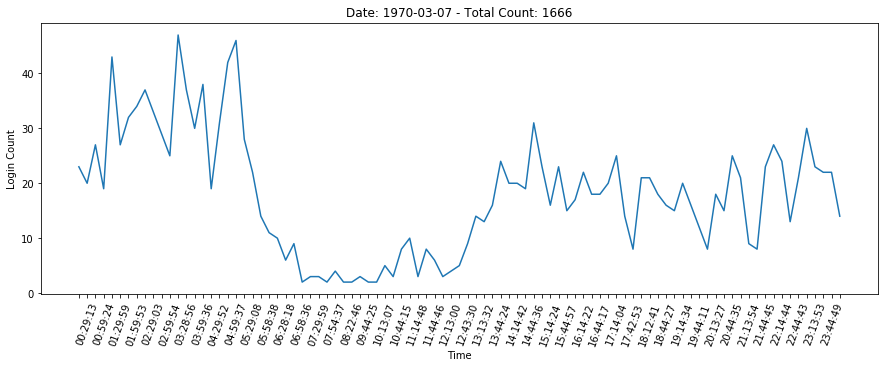

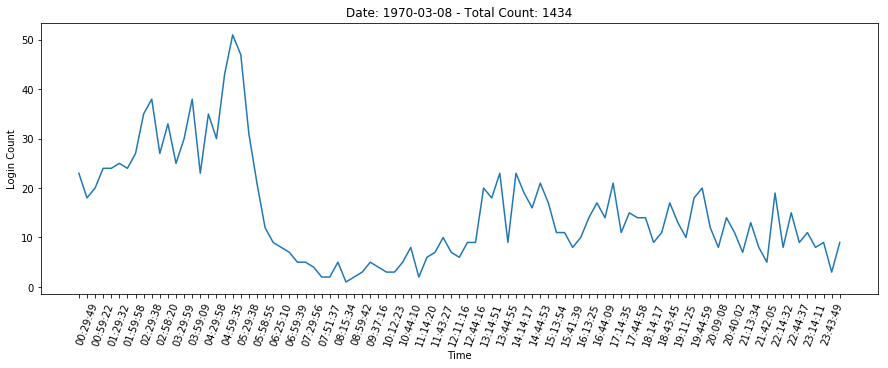

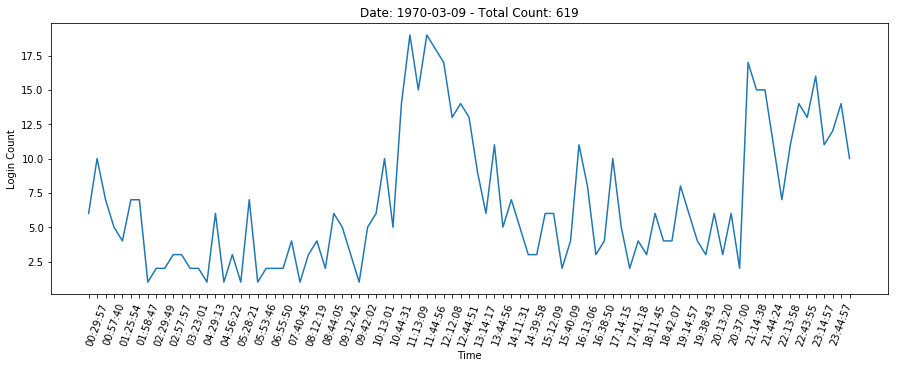

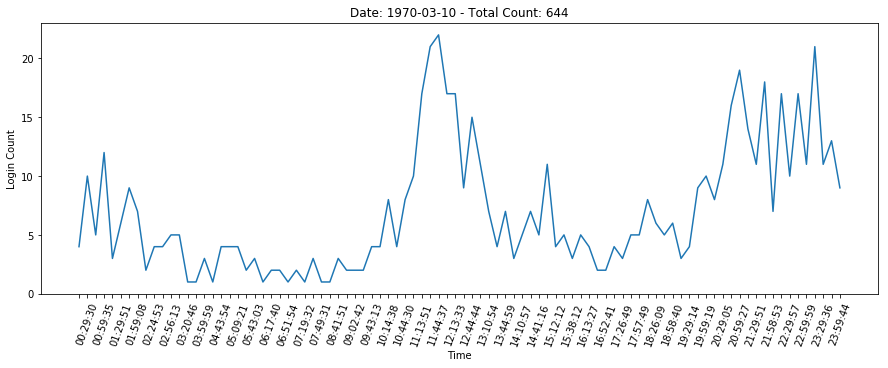

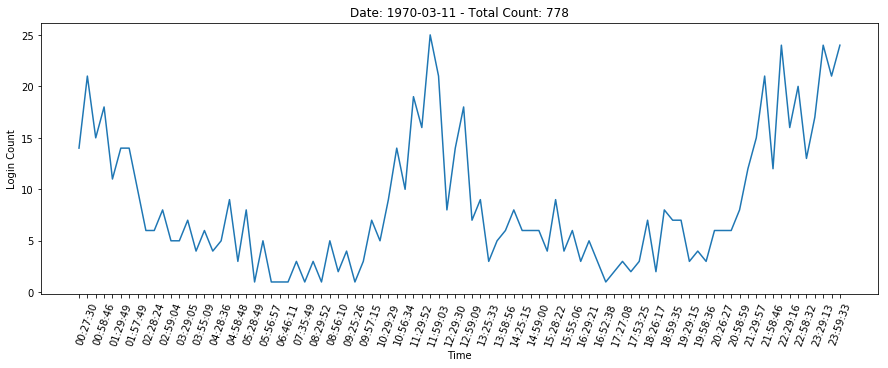

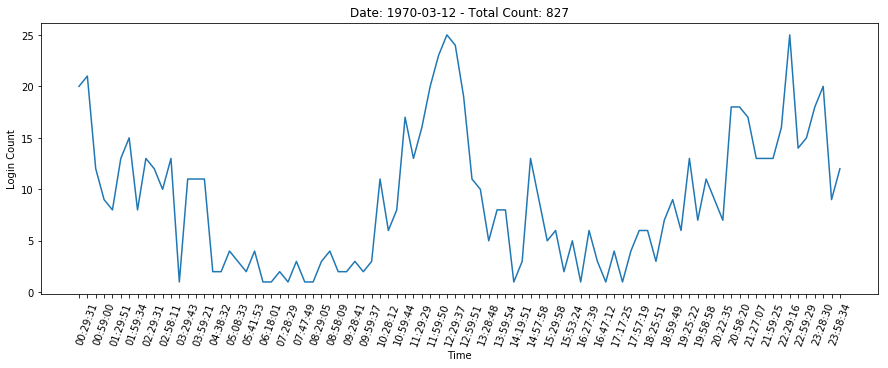

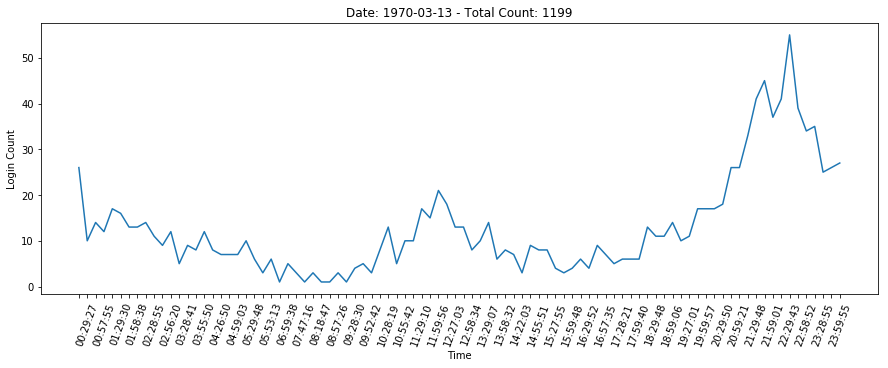

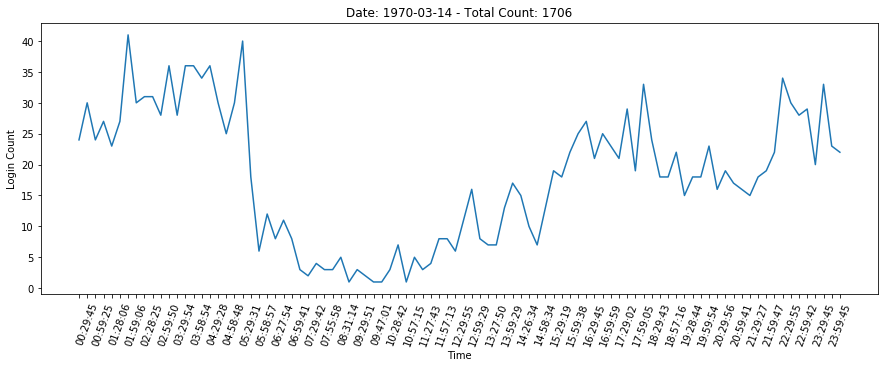

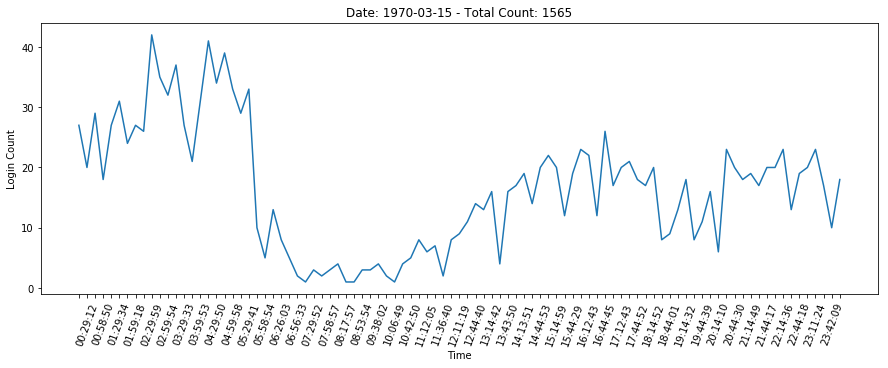

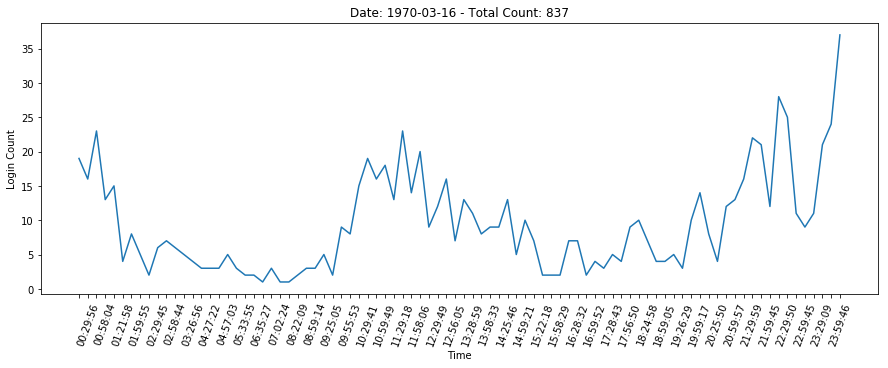

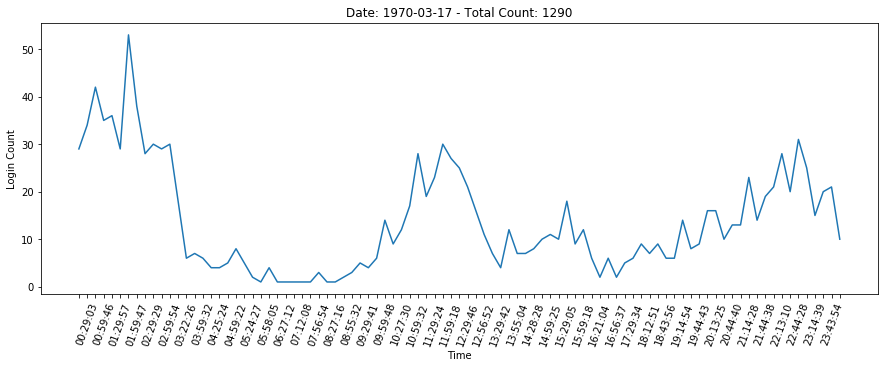

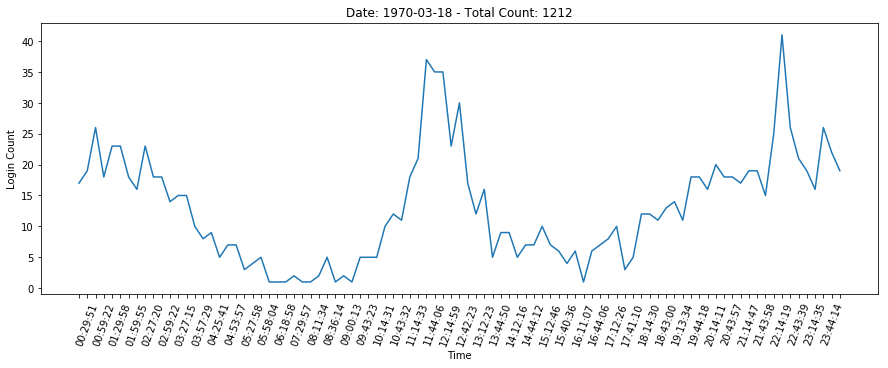

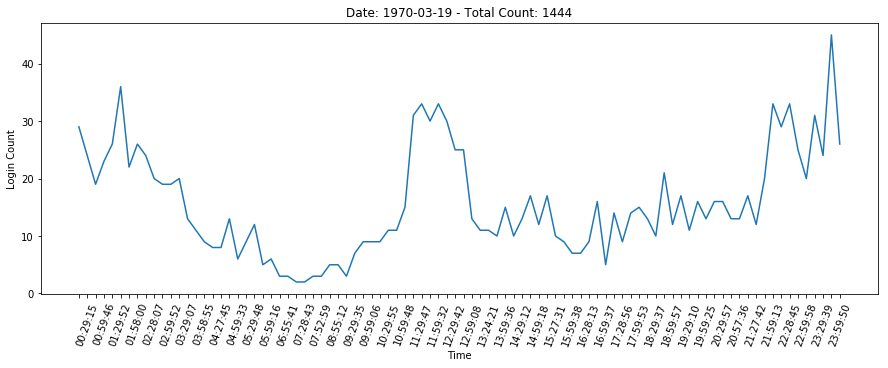

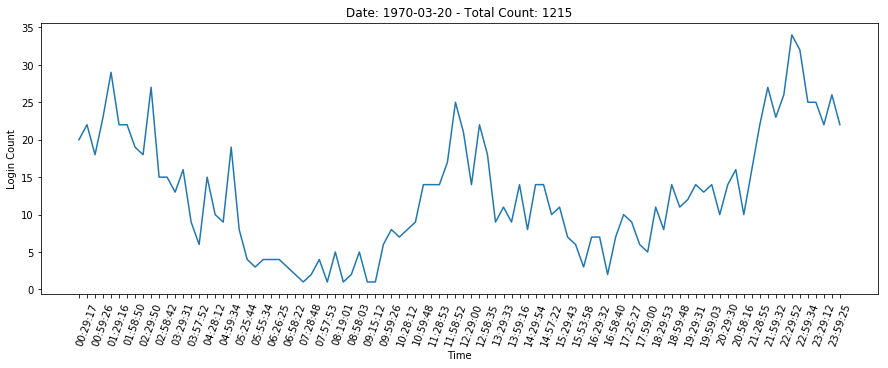

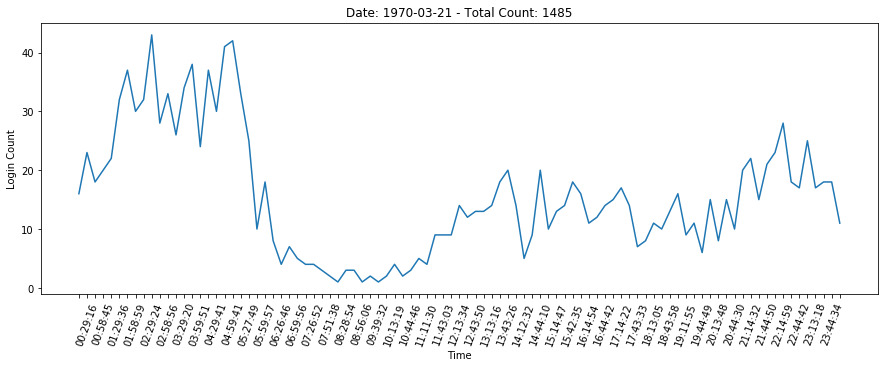

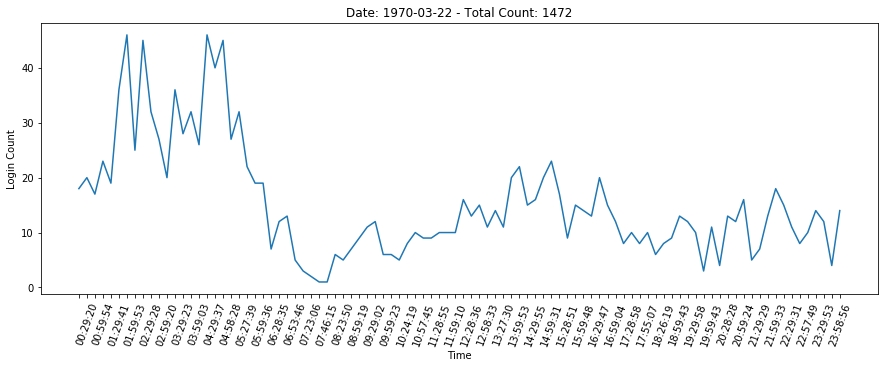

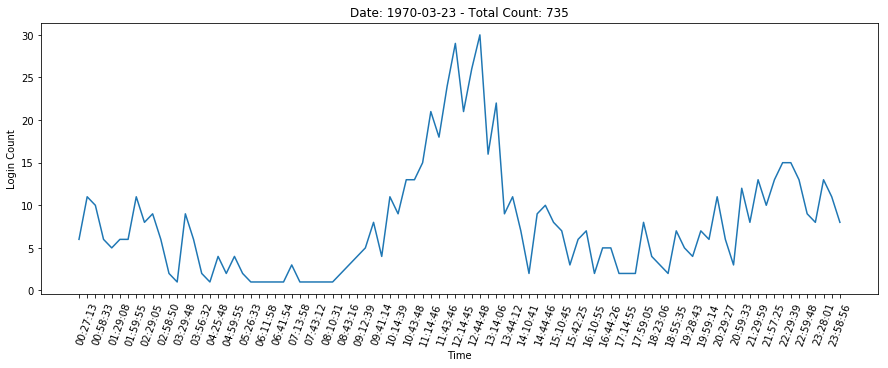

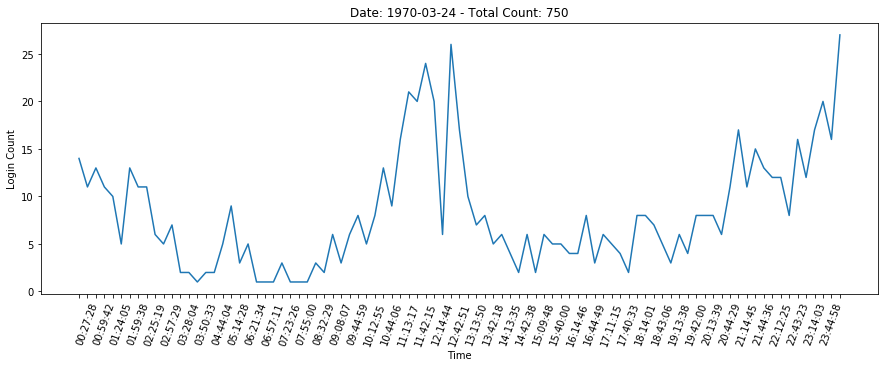

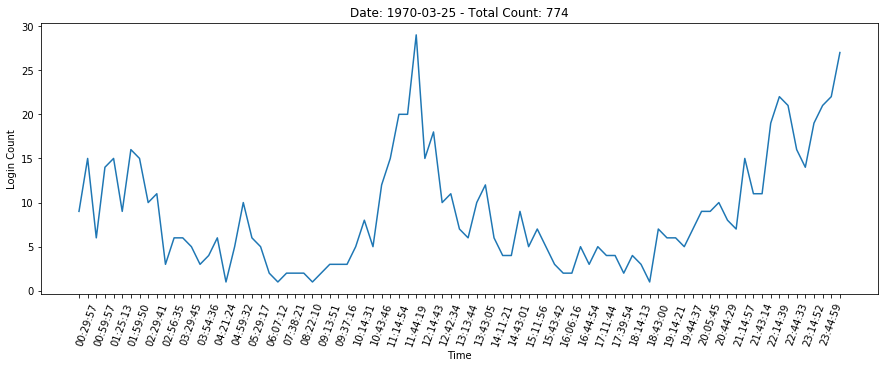

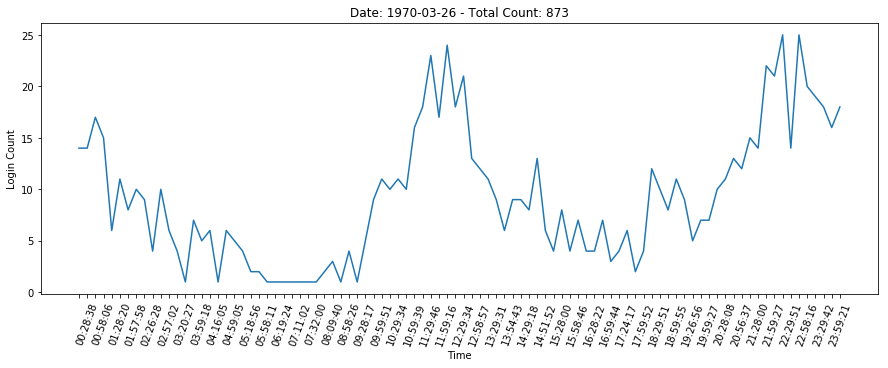

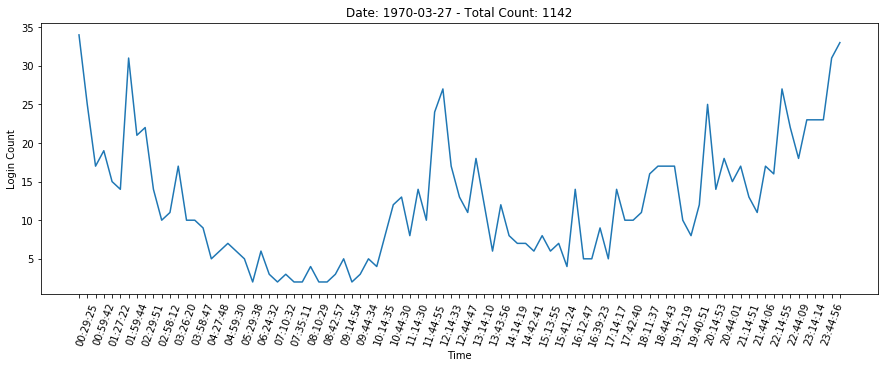

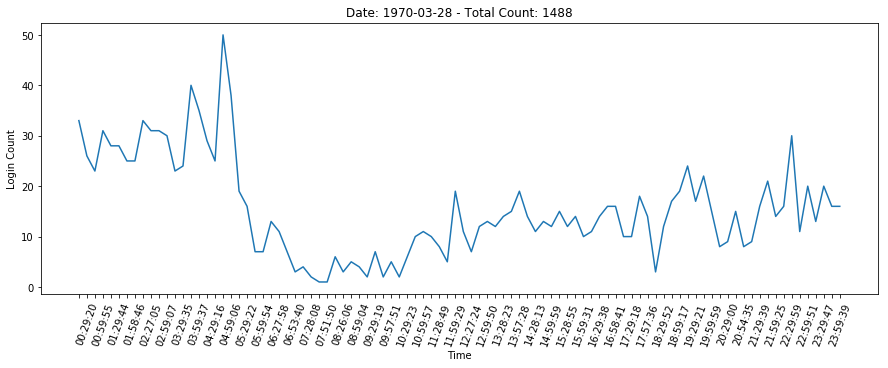

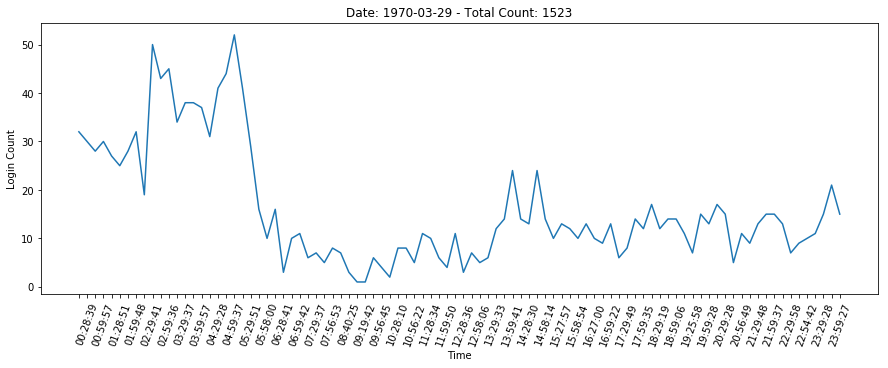

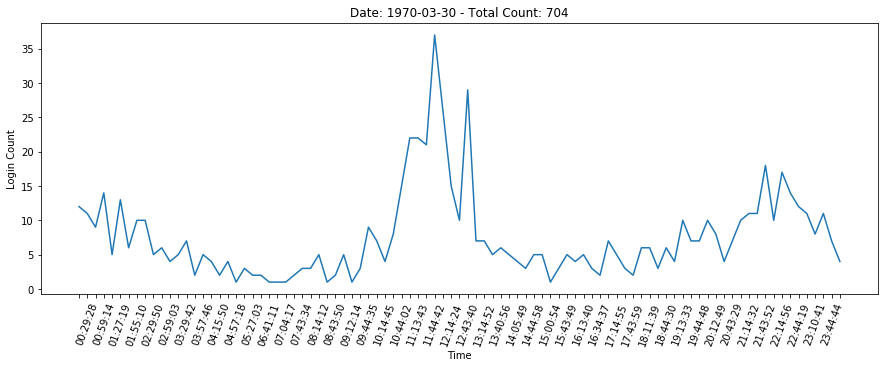

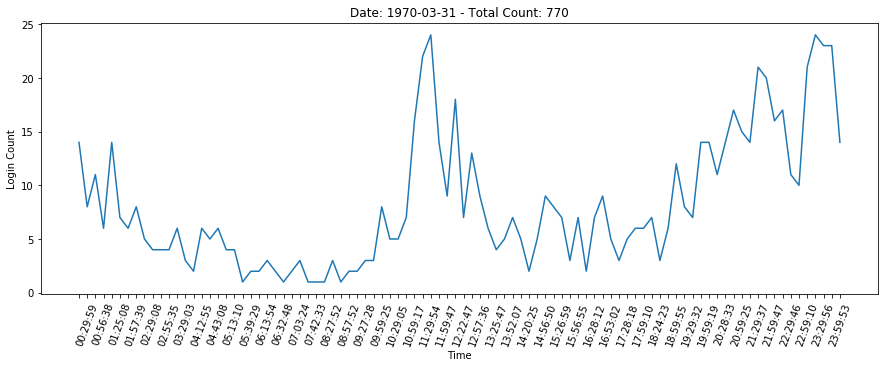

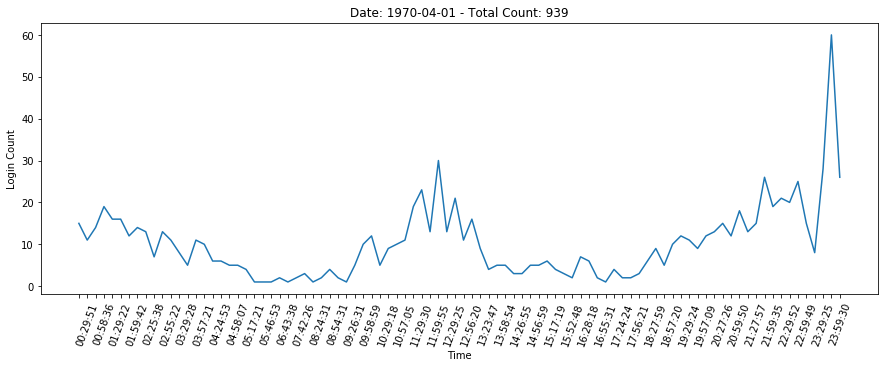

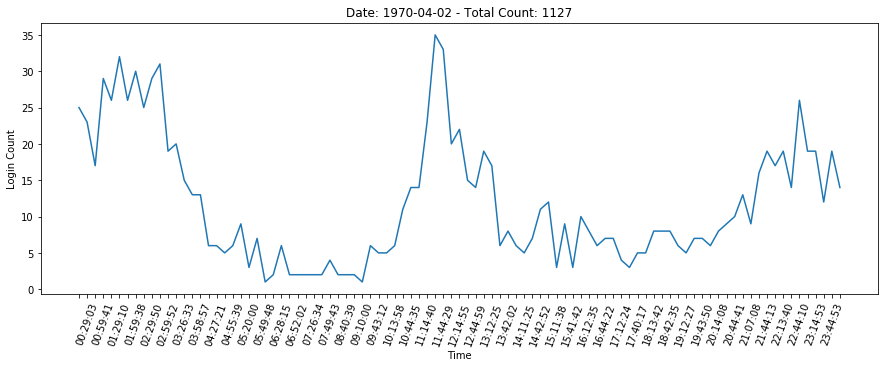

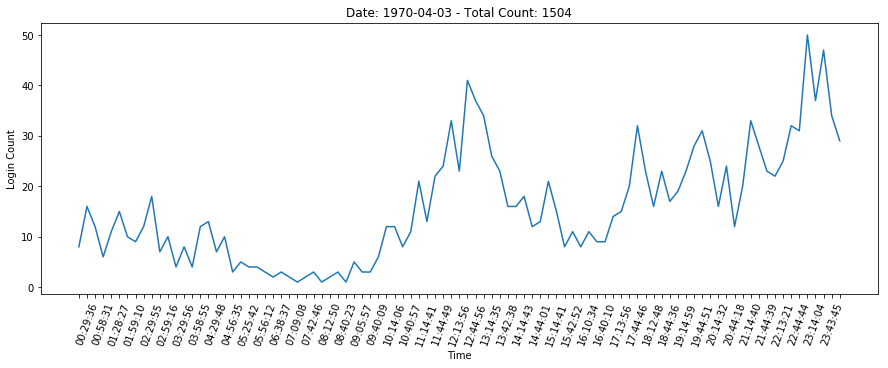

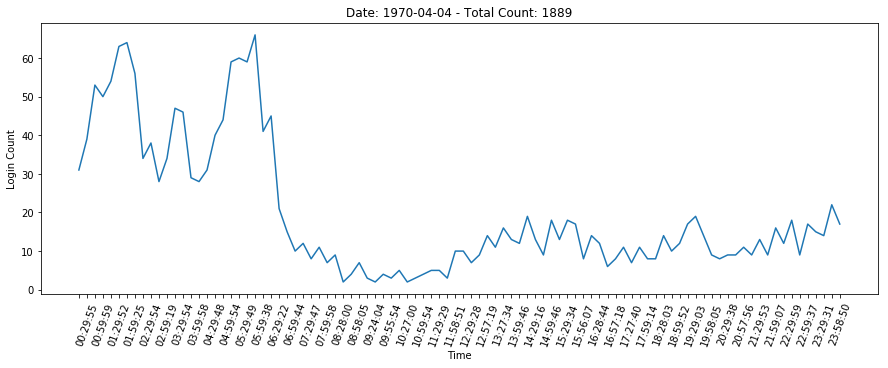

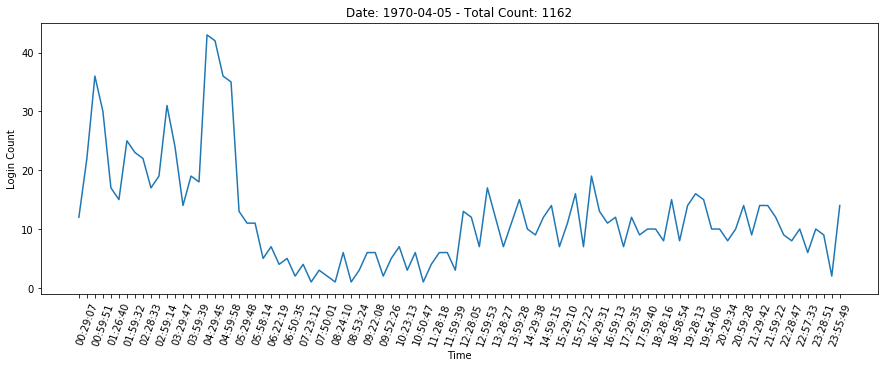

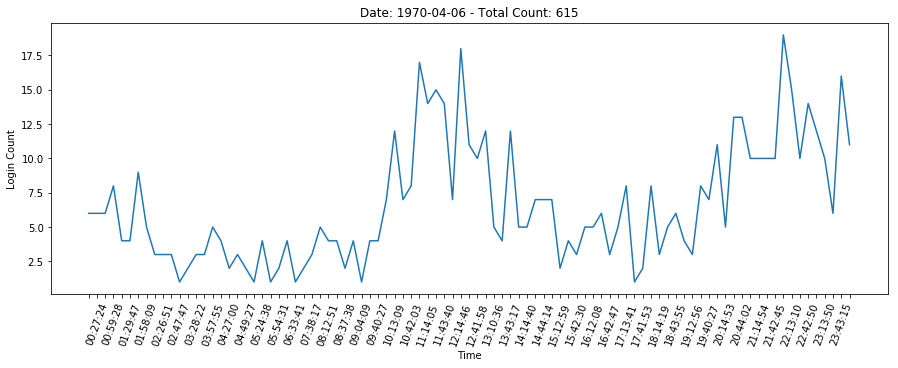

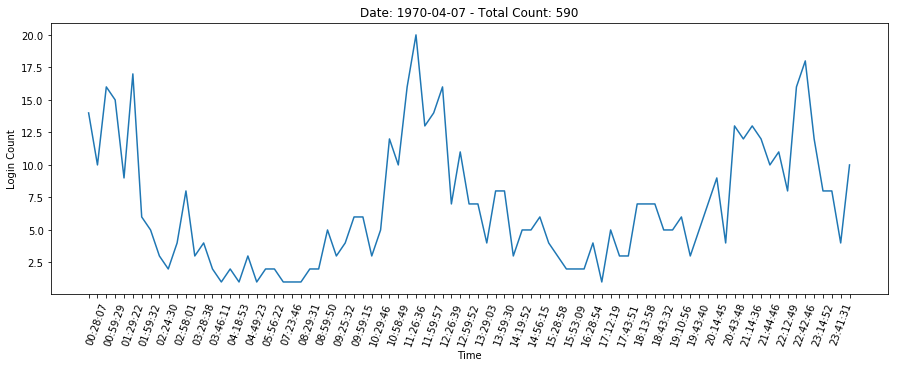

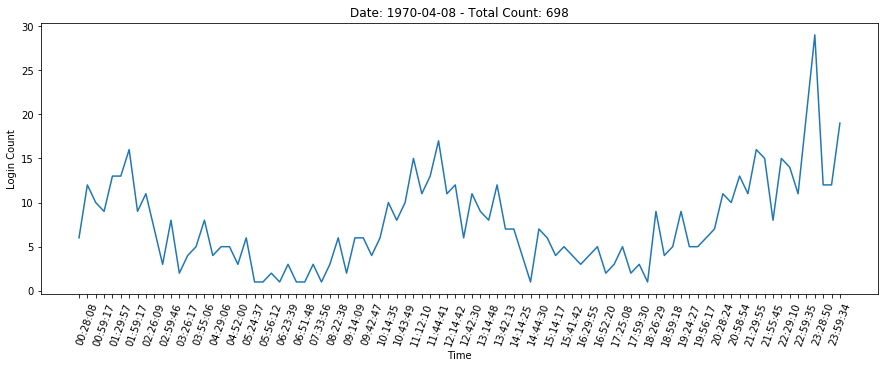

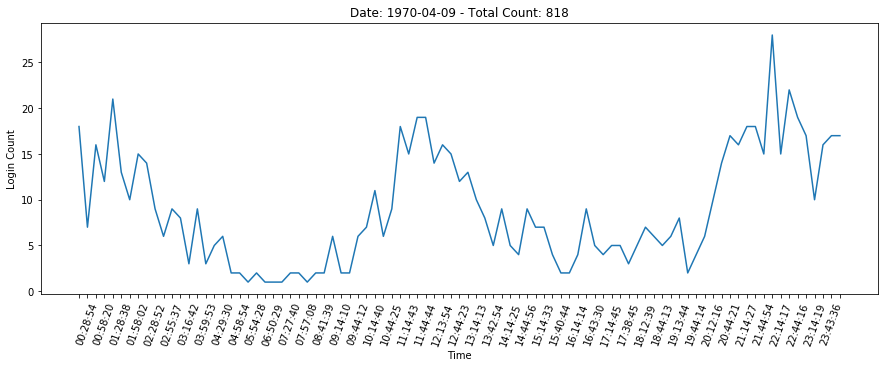

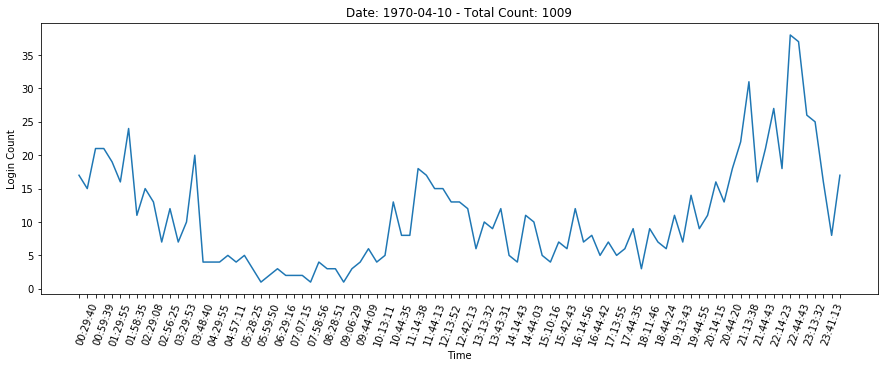

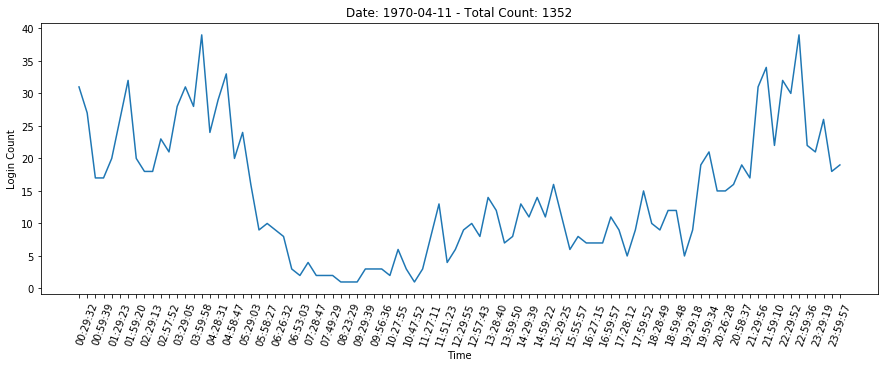

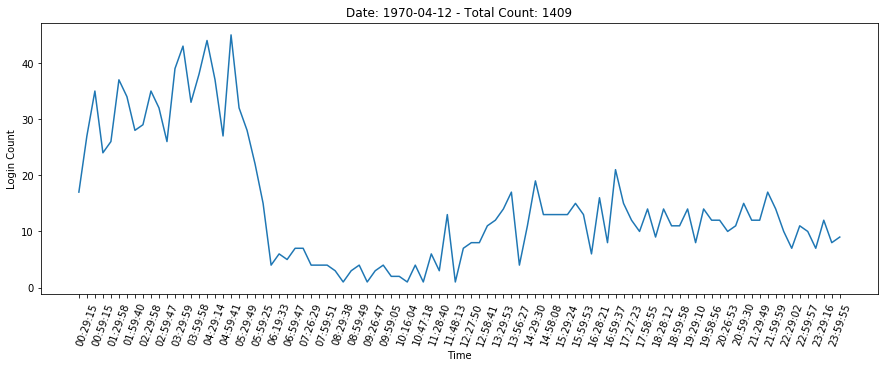

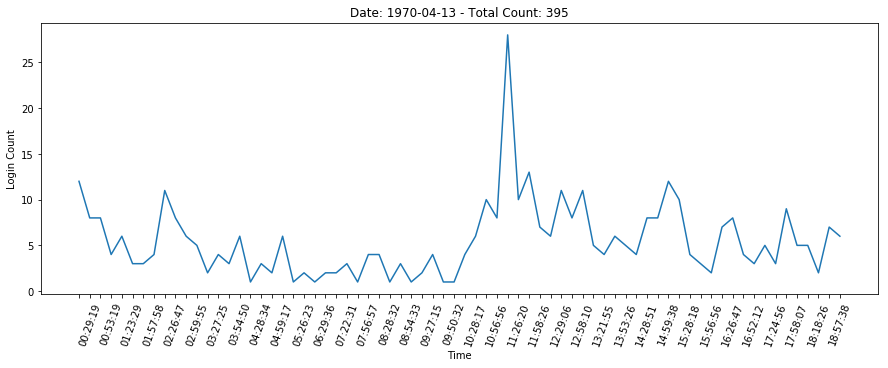

In [28]:
dateLst=sorted(list(set(df["date_max"])))
for i in range(0,len(dateLst)):
    date=dateLst[i]
    plotLoginCntFunc(df,date)

## Part 2

**1.) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

**Ans: I would choose the "Toll costs" as the key measure for this experiment. Since the company design the incentive which reimbursing "Toll Costs" attracts driver to serve both cities, So that I could assume that the more toll fee claim by the driver, the more the driver serving both cities.**

**2a.) How to set up the experiment?**

**Ans: The company should first record every trip of the drivers and then calculate the ratio of the driver serves both cities (i.e. Let's call it Serve_Ratio). For example, if the driver serves Gotham 5 trips/day, serves Metropolis 10 times/ day, the rato equals 5/10=0.5. In other words, the ratio would be close to 1 if a driver constantly serves both cities (i.e. NOT exclusive only to  one city)**

**2b.)what statistical test(s) you will conduct to verify the significance of the observation?**

**Ans: After recording the Serve_Ratio and Toll_Cost, we are able to proceed to implement a Hypothesis test to verify if "Reimbursing Toll Cost" would encourage driver serving both cities. In other words, we would find out whether Toll_cost would correlate to the Serve_ratio. For the test, we first need to set up the hypothesis which is shown as below. Once we have the test result, we could conclude whether these two factors have straight relationshp. For example, if P-Value < 0.05, then we could reject the Null Hypothesis which Toll_Cost do NOT correlate to Serve_Raio. In other words, we will strong evidence to show that Toll_Cost correlates to Serve_Raio (The higher the Toll_Cost, the Serve_Ratio more close to 1)**

    *- Null: Toll_Cost do NOT correlate to Serve_Raio*

    *- Alt: Toll_Cost correlates to Serve_Raio*
    
    
**2c.) How you would interpret the results and provide recommendations to the city
operations team along with any caveats.**

**Ans: There are several recommendations with caveats:**
    
    * - City would need to grant more incentives to drivers for passing toll-bridge (e.g. No need to query in line to pass)*
    
    * - Cities might be cautious to plan heavier traffic crossing bridge with more drivers serve both cities *
    


## Part 3

## Read Ultimate Data Json
The following analysis is based on dataset given by a company which is called "Ultimate". The features of the dataset includes activities of  anonymous drivers as shown below. The purpose of this report is to discover any specific pattern from this dataset and to build a predictive model to forecast whether a driver would be still active using "Ultimate" service in their 6th month in the system. For the machine learning purpose, target labels are then formatted as below:

<font, color="blue">label = 1 </font> *if last trip date > 2014-05-31*
OR <font, color="blue">label = 0 </font> *if last trip date <= 2014-05-31*

#### Features
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

#### Report Contents
 - Exploratory Data Analysis (EDA)
 - Convert Categorical variables to Binary format (i.e.1,0)
 - Normalize Continuous Variables
 - Build Machine Learning models
 - Models comparison (t-test)
 - Receiver Operating Characteristics (ROC - AUC)

In [12]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [577]:
'''ultimate_data_challenge json'''
import json
with open ("ultimate_data_challenge.json") as f:
    data=json.load(f) 
df=pd.DataFrame.from_dict(data)
print(df.shape)
pd.set_option('display.max_colwidth', -1)

'''Convet columns to datetime'''
df["last_trip_date"] = pd.to_datetime(df.last_trip_date)
df["signup_date"] = pd.to_datetime(df.signup_date)

'''
Add Target label Column 
last_trip_date > 2014/05/31 will be assigned as 1, otherwise 0
'''
df["label"]=np.zeros(df.shape[0])
df["label"][df["last_trip_date"] > pd.to_datetime("2014-05-31")] =1
df["label"]=list(map(int,df["label"]))


print("Original data Size: %d"%(df.shape[0]))
df.dropna(axis=0, inplace=True)                                                       
print("After Dropping missing value Size:", df.shape[0])
df.head(5)

(50000, 12)
Original data Size: 50000
After Dropping missing value Size: 41445


/Users/KevQuant/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  3.67      5.0                   4.7                   1.10        
1  8.26      5.0                   5.0                   1.00        
2  0.77      5.0                   4.3                   1.00        
3  2.36      4.9                   4.6                   1.14        
4  3.13      4.9                   4.4                   1.19        

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing 2014-06-17      iPhone  2014-01-25   15.4        
1  Astapor        2014-05-05      Android 2014-01-29   0.0         
2  Astapor        2014-01-07      iPhone  2014-01-06   0.0         
3  King's Landing 2014-06-29      iPhone  2014-01-10   20.0        
4  Winterfell     2014-03-15      Android 2014-01-27   11.8        

   trips_in_first_30_days  ultimate_black_user  weekday_pct  label  
0  4                       True                 46.2         1      
1  0                       False                50.0         0      
2  3                       False                100.0        0      
3  9                       True                 80.0         1      
4  14                      False                82.4         0

### Signup date Range

In [521]:
set(df.signup_date)

{Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2014-01-03 00:00:00'),
 Timestamp('2014-01-04 00:00:00'),
 Timestamp('2014-01-05 00:00:00'),
 Timestamp('2014-01-06 00:00:00'),
 Timestamp('2014-01-07 00:00:00'),
 Timestamp('2014-01-08 00:00:00'),
 Timestamp('2014-01-09 00:00:00'),
 Timestamp('2014-01-10 00:00:00'),
 Timestamp('2014-01-11 00:00:00'),
 Timestamp('2014-01-12 00:00:00'),
 Timestamp('2014-01-13 00:00:00'),
 Timestamp('2014-01-14 00:00:00'),
 Timestamp('2014-01-15 00:00:00'),
 Timestamp('2014-01-16 00:00:00'),
 Timestamp('2014-01-17 00:00:00'),
 Timestamp('2014-01-18 00:00:00'),
 Timestamp('2014-01-19 00:00:00'),
 Timestamp('2014-01-20 00:00:00'),
 Timestamp('2014-01-21 00:00:00'),
 Timestamp('2014-01-22 00:00:00'),
 Timestamp('2014-01-23 00:00:00'),
 Timestamp('2014-01-24 00:00:00'),
 Timestamp('2014-01-25 00:00:00'),
 Timestamp('2014-01-26 00:00:00'),
 Timestamp('2014-01-27 00:00:00'),
 Timestamp('2014-01-28 00:00:00'),
 Timestamp('2014-01-

## Convert Categorical Cols into Binary Col for each Category

In [599]:
df_dummy = pd.get_dummies(df, columns=["city", "phone", "ultimate_black_user"])
print(df_dummy.shape)
df_dummy.head(3)

(41445, 17)


avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  3.67      5.0                   4.7                   1.1         
1  8.26      5.0                   5.0                   1.0         
2  0.77      5.0                   4.3                   1.0         

  last_trip_date signup_date  surge_pct  trips_in_first_30_days  weekday_pct  \
0 2014-06-17     2014-01-25   15.4       4                       46.2          
1 2014-05-05     2014-01-29   0.0        0                       50.0          
2 2014-01-07     2014-01-06   0.0        3                       100.0         

   label  city_Astapor  city_King's Landing  city_Winterfell  phone_Android  \
0  1      0             1                    0                0               
1  0      1             0                    0                1               
2  0      1             0                    0                0               

   phone_iPhone  ultimate_black_user_False  ultimate_black_user_True  
0  1             0                          1                         
1  0             1                          0                         
2  1             1                          0

## Target Label Counts
The following plot which shows the proportion of Target labels Active drivers are about 20% more than the Non-Active driver. In this case, I would not consider this is a biased dataset. 

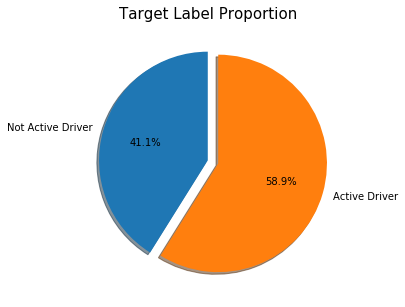

In [5]:
label_count=Counter(df.label)
labelDf=pd.DataFrame.from_dict(dict(label_count), orient="index").reset_index()
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.figure(figsize=(5,5))
plt.pie(labelDf[0], explode=explode,
        labels=["Not Active Driver","Active Driver"], 
        autopct="%1.1f%%",
        shadow=True, startangle=90)
plt.title("Target Label Proportion", fontsize=15)
#plt.legend()
plt.show()

## Continuous Variable vs Target Label

 - avg_dist: Target group 1 has narrower range of average of distance driving (i.e. 0-10); Group 0 has wider range of distance driving (i.2. 0-15)
 - avg_rating_by_driver: The target group 1 has the wider range of rating (i.e. 4-5) by driver; the group 0 seems
 have narrower range of rating (i.e.4.6-5) by driver. However, the range difference between two groups are not too huge to be aware
 - avg_rating_of_driver: There is NO noticable variations between two groups
 - avg_surge: The group 0 has zero range in this feature; the group 1 has a wider range of ave_surge (i.e. 1-1.25). Due to this obvious disparity, I would recommend to pay more attention on this factor to see if the importance of this factor in machine learning process. 
 - surge_pct: Same as the avg_surge feature, the group 0 has 0 range in this feature; group 1 has wide range (i.e. 0-35). Due to this obvious disparity, I would recommend to pay more attention on this factor to see if the importance of this factor in machine learning process. 
 - trips_in_first_30_days: There is dissimilarity between 2 groups in this feature. The group 1 has a wide range 0-12 ; the range of group 0 is half of group 1 which is only 0-5.5. Due to this obvious disparity, I would recommend to pay more attention on this factor to see if the importance of this factor in machine learning process.
 - weekday_pct: The range of this feature is similar between two groups except the 25%-75% percentile is larger for group 0.

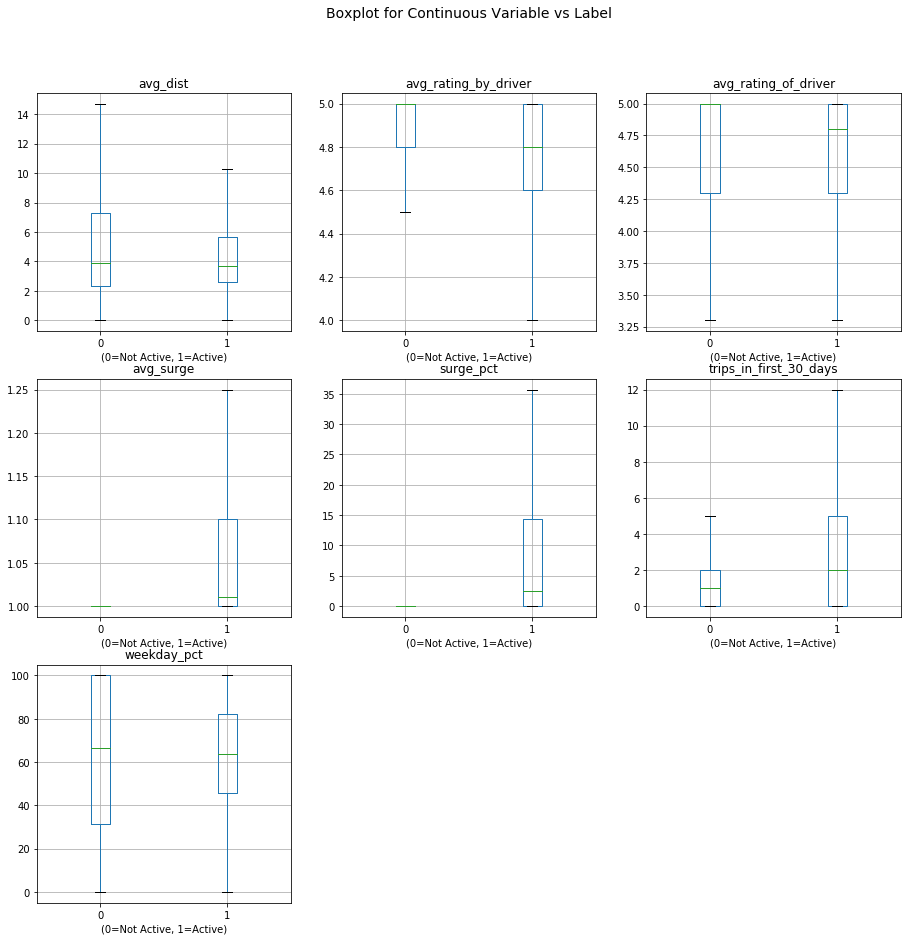

In [238]:
import seaborn as sns

fig=plt.figure(figsize=(15,15))

cols=["avg_dist","avg_rating_by_driver", 
      'avg_rating_of_driver', 'avg_surge', "surge_pct",
      "trips_in_first_30_days","weekday_pct"]

for i in range(len(cols)):
    ax1=fig.add_subplot(3,3,i+1)
    df.boxplot(column=cols[i], 
               by="label", 
               ax=ax1, 
               showfliers=False ) # outliers are NOT shown
    plt.xlabel("(0=Not Active, 1=Active)")
    
fig.suptitle("Boxplot for Continuous Variable vs Label", fontsize=14)
plt.show()

## CrossTab

 - Feature *City*: Winterfell has the most users signed up "Ultimate" service in both group of driver. The group non-active driver is approximately double Winterfell and Astapor except King's Landing. Although the total count of driver is the least in King's Landing, the active driver is in second place among the three cities. Based on this result, the company could look into this metric to discover more info. 
 
 - Feature *Phone*: The overall count of iPhone users is approximately double than Android users in both driver groups. The large portion of Android users are also non-activer users. The proportion of iPhone users evenly diversed into 2 groups.
 
 - Feature *Ultimate-Black-user*: The plot shows that total count of "Black" users is almost one half of the non-Black users. However, the active users in both group is the same. In this case, I would believe this relate to incentive to attract users to sign up the "Ultimate-Black" service. 

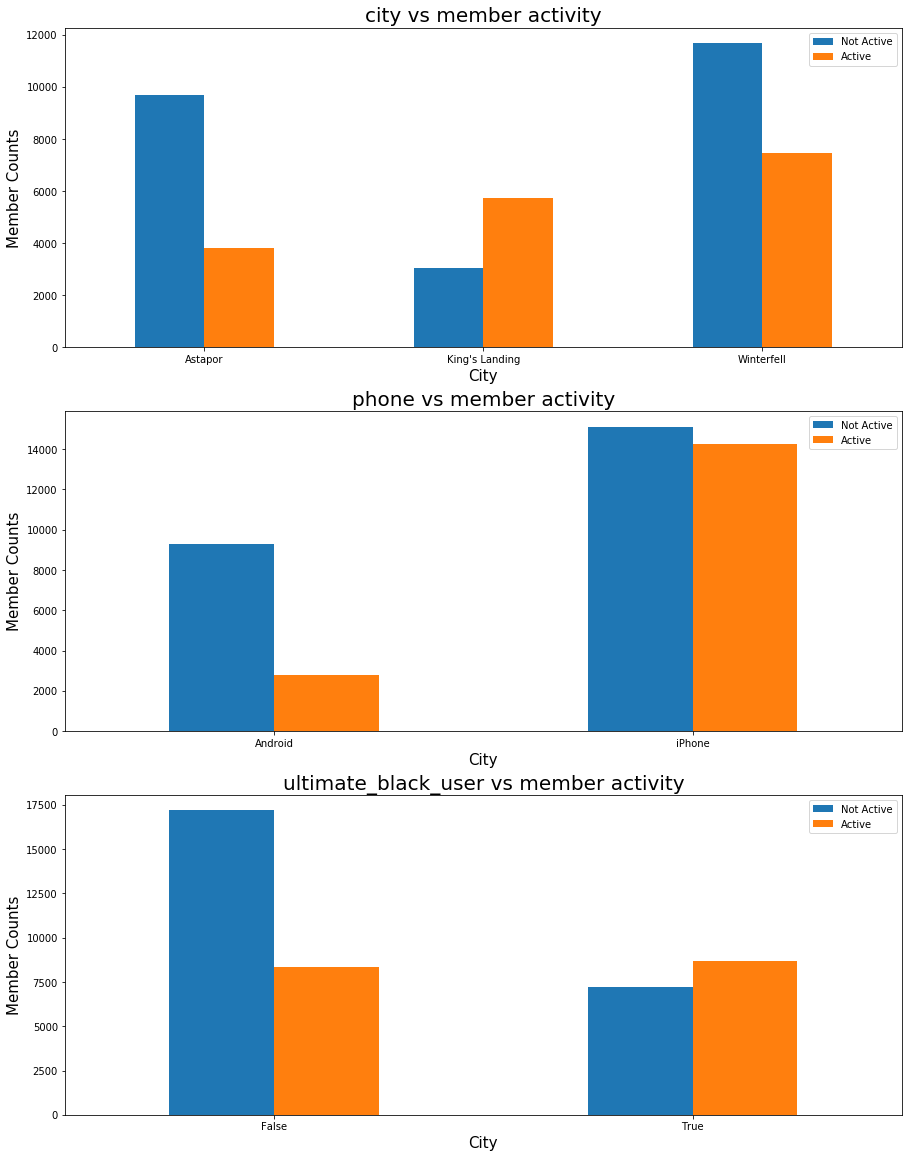

In [7]:
fig= plt.figure(figsize=(15,20))

cols=["city", "phone","ultimate_black_user"]
for i in range(len(cols)):
    ax=fig.add_subplot(3,1,i+1)
    ct=pd.crosstab(df[cols[i]], df.label)
    ct.plot.bar(ax=ax)
    plt.legend(["Not Active = 0", "Active = 1"])
    plt.xlabel("City", fontsize=15)
    plt.ylabel("Member Counts", fontsize=15)
    plt.title("%s vs member activity" %(cols[i]), fontsize=20)
    plt.xticks(rotation=0)

plt.show()

## Correlation Table
Summary: The correlation table below indicates the how the features correlates with each other. Firstly, let's take a look of how the predictor features react with Target label. The corrlelation values overall is not high versus the label, the highest value is about 0.24 regardless the sign of correlations. In this case, the most noticeable correlated features with label are "avg_rating_by_driver", "avg_surge", "surge_pct" and "ultimate_black_user" ranging 0.22-0.24 in terms of correlation values. This result illustrates the similar pattern comparing with the above plots. In addition, we could also observe the features "avg_surge" and "surge_pct" wahich are highly correlated with each other have 0.99 correlation value, this result shows that our findings above alignes with the computed correlation values. We should pay more attention to the result of machine learning part to see how the contribution of these features to the models. 

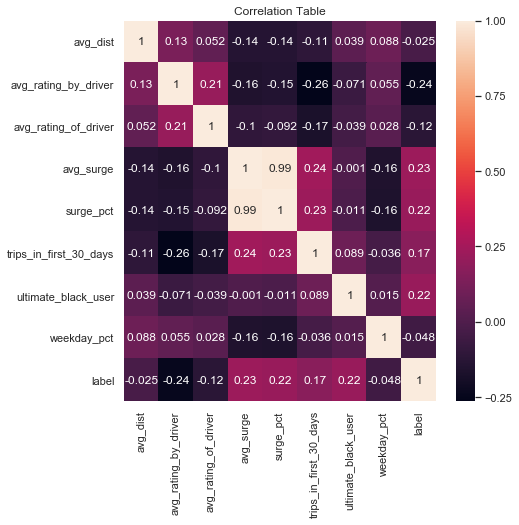

In [538]:
import seaborn as sns
plt.figure(figsize=(7,7))
ax=sns.heatmap(df.corr(method="spearman"), annot=True)
plt.title("Correlation Table")
#plt.xticks(rotation=45)
plt.show()

## Prepare dataset for Machine Learning

In [600]:
'''
Calculate the days difference from signup day to last trip day
i.e. signup_last_date_diff = signup_date - last_trip_date
'''
df_dummy["signup_last_date_diff"] = df_dummy["last_trip_date"]- df_dummy["signup_date"]
df_dummy["signup_last_date_diff"]=df_dummy["signup_last_date_diff"].dt.days
df_dummy.head(5)

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0  3.67      5.0                   4.7                   1.10        
1  8.26      5.0                   5.0                   1.00        
2  0.77      5.0                   4.3                   1.00        
3  2.36      4.9                   4.6                   1.14        
4  3.13      4.9                   4.4                   1.19        

  last_trip_date signup_date  surge_pct  trips_in_first_30_days  weekday_pct  \
0 2014-06-17     2014-01-25   15.4       4                       46.2          
1 2014-05-05     2014-01-29   0.0        0                       50.0          
2 2014-01-07     2014-01-06   0.0        3                       100.0         
3 2014-06-29     2014-01-10   20.0       9                       80.0          
4 2014-03-15     2014-01-27   11.8       14                      82.4          

   label  city_Astapor  city_King's Landing  city_Winterfell  phone_Android  \
0  1      0             1                    0                0               
1  0      1             0                    0                1               
2  0      1             0                    0                0               
3  1      0             1                    0                0               
4  0      0             0                    1                1               

   phone_iPhone  ultimate_black_user_False  ultimate_black_user_True  \
0  1             0                          1                          
1  0             1                          0                          
2  1             1                          0                          
3  1             0                          1                          
4  0             1                          0                          

   signup_last_date_diff  
0  143                    
1  96                     
2  1                      
3  170                    
4  47

## Normalize Continuous Columns

In [601]:
cols=["avg_dist","avg_rating_by_driver", "avg_rating_of_driver", "avg_surge","surge_pct",
     "trips_in_first_30_days", "weekday_pct","signup_last_date_diff"]
#      ,       "last_trip_month", "signup_month"]

for col in cols:
    df_dummy[col] = (df_dummy[col] -df_dummy[col].mean() )/ df_dummy[col].std()

df_dummy.head(5)

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0 -0.347908  0.552522              0.159518              0.131717    
1  0.544190  0.552522              0.646448             -0.371435    
2 -0.911543  0.552522             -0.489723             -0.371435    
3 -0.602515  0.305369             -0.002792              0.332977    
4 -0.452861  0.305369             -0.327413              0.584553    

  last_trip_date signup_date  surge_pct  trips_in_first_30_days  weekday_pct  \
0 2014-06-17     2014-01-25   0.354834   0.342501               -0.432440      
1 2014-05-05     2014-01-29  -0.485683  -0.642882               -0.323288      
2 2014-01-07     2014-01-06  -0.485683   0.096155                1.112922      
3 2014-06-29     2014-01-10   0.605897   1.574229                0.538438      
4 2014-03-15     2014-01-27   0.158350   2.805958                0.607376      

   label  city_Astapor  city_King's Landing  city_Winterfell  phone_Android  \
0  1      0             1                    0                0               
1  0      1             0                    0                1               
2  0      1             0                    0                0               
3  1      0             1                    0                0               
4  0      0             0                    1                1               

   phone_iPhone  ultimate_black_user_False  ultimate_black_user_True  \
0  1             0                          1                          
1  0             1                          0                          
2  1             1                          0                          
3  1             0                          1                          
4  0             1                          0                          

   signup_last_date_diff  
0  0.733589               
1 -0.034462               
2 -1.586905               
3  1.174810               
4 -0.835196

## Drop Columns only showing dates

In [602]:
df_dummy.drop(columns = ["last_trip_date", "signup_date", "signup_last_date_diff"], inplace=True)
df_dummy.head(5)

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  surge_pct  \
0 -0.347908  0.552522              0.159518              0.131717   0.354834    
1  0.544190  0.552522              0.646448             -0.371435  -0.485683    
2 -0.911543  0.552522             -0.489723             -0.371435  -0.485683    
3 -0.602515  0.305369             -0.002792              0.332977   0.605897    
4 -0.452861  0.305369             -0.327413              0.584553   0.158350    

   trips_in_first_30_days  weekday_pct  label  city_Astapor  \
0  0.342501               -0.432440     1      0              
1 -0.642882               -0.323288     0      1              
2  0.096155                1.112922     0      1              
3  1.574229                0.538438     1      0              
4  2.805958                0.607376     0      0              

   city_King's Landing  city_Winterfell  phone_Android  phone_iPhone  \
0  1                    0                0              1              
1  0                    0                1              0              
2  0                    0                0              1              
3  1                    0                0              1              
4  0                    1                1              0              

   ultimate_black_user_False  ultimate_black_user_True  
0  0                          1                         
1  1                          0                         
2  1                          0                         
3  0                          1                         
4  1                          0

## Store modified data to pickle

In [603]:
import pickle

with open("./data/XnormalizedDataPickle", "wb") as file:
    pickle.dump(np.array(df_dummy.drop(columns=["label"])),file)
    
with open("./data/ynormalizedDataPickle", "wb") as file:
    pickle.dump(np.array(df_dummy["label"]),file)    

## Reload modified data from pickle

In [604]:
with open("./data/XnormalizedDataPickle", "rb") as file:
    X = pickle.load(file)
    
with open("./data/ynormalizedDataPickle", "rb") as file:
    y = pickle.load(file)      
    
print(X.shape, y.shape)
#print(X.head(3), y.head(3))    

(41445, 14) (41445,)


## Build Models

Summary: Let's recall the goal of this project which is to forecast whether the driver is still active in their 6th month after signing up the Ultimate service. In this case, we should focus finding out drivers would like to stay suing Ultimate servce which means we need to find out drivers with label = 1. For this reason, I would propose to use overall Accuracy and Recall (i.e. TPR) as the primary metric to measure the performance of classifiers.

The following shows the performance of models (i.e. <font, color="blue"> Logistic Regression, Gradient Boosting Classifier and Random Forest Classifier</font>). The plots show the overall Accuracy as well as Recall metrics for the Classifiers. The models were built by using **10 Cross-Validation* method**, the performance graphs show how the metrics varies for each learning iteration. As observed, all three classifers perform differently by training the given dataset, the average Accuracy is around <font, color="blue"> 69-78%</font>; the average Recall is also around <font, color="blue"> 70-75%</font>. 

### Logistic Regressor:
Overall Average Accuracy of Train and Test set aligns in range 70-72%. Average AUC value is around 75%. There is NO overfitting or under-fitting found from this model.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf= LogisticRegression(random_state=1)
cv=10
scoring = {'accuracy': make_scorer(accuracy_score)} 
#{'auc': 'roc_auc'} 
        
grid = {
    "penalty": ["l1","l2"],
    "C": [0.1,1,10]
}


gsearch = GridSearchCV(estimator=clf, 
                       param_grid= grid, 
                       cv=cv, 
                       scoring=scoring, 
                       refit="accuracy",
                       return_train_score=True)
gsearch.fit(X, y)


In [606]:
'''
Plot GridSearch Accuracy and Recall
'''

def plot_logistic_gridsearch(train_or_test, metric, cv):
    lst=[]
    for i in range(0,cv):
        if i ==0: lst= gsearch.cv_results_["split%s_%s_%s"%(str(i), train_or_test, metric)]
        else: lst=np.vstack((lst, gsearch.cv_results_["split%s_%s_%s"%(str(i), train_or_test, metric)]))

    colNames=[]
    for i in range(len(gsearch.cv_results_["params"])):
        p=gsearch.cv_results_["params"][i]['penalty']
        c=gsearch.cv_results_["params"][i]['C']

        string = "C:%s , penalty:%s" %(str(c),str(p))

        colNames.append(string)        

    metricDf=pd.DataFrame(lst, columns= colNames)

    #fig=plt.figure(figsize=(15,8))
    metricDf.plot(figsize=(15,5))
    plt.xticks(ticks=np.arange(0,10), labels=np.linspace(1,11,11, dtype=int))
    plt.xlabel("CV")
    plt.ylabel("%s"%(metric))
    plt.title("%s Set %s" %(train_or_test, metric))
    plt.legend()
    plt.show()

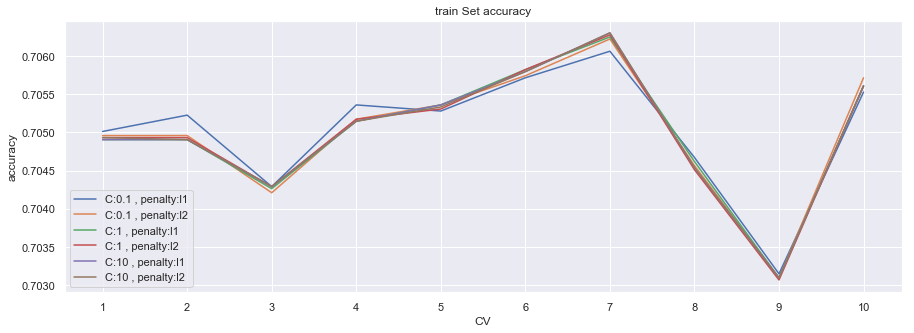

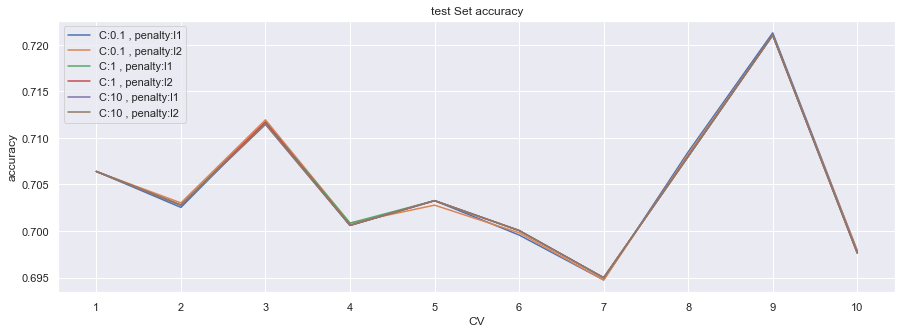

Best Parameters:{'C': 0.1, 'penalty': 'l2'} with score 70.47% based on Accuracy


In [625]:
plot_logistic_gridsearch("train", "accuracy", cv)
plot_logistic_gridsearch("test", "accuracy", cv)
print("Best Parameters:%s with score %s%% based on Accuracy"%(gsearch.best_params_, str(round(gsearch.best_score_*100,2))))

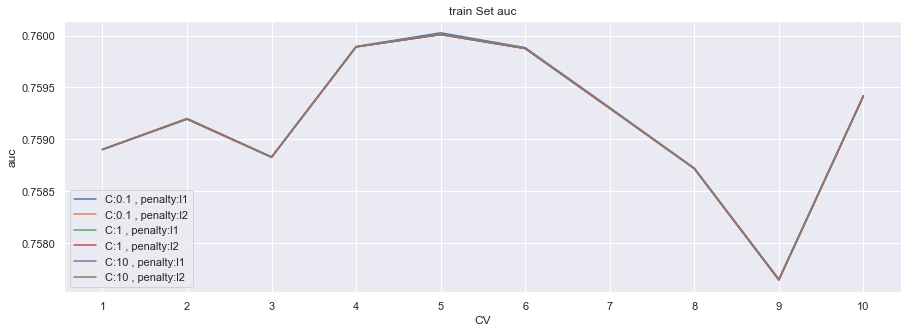

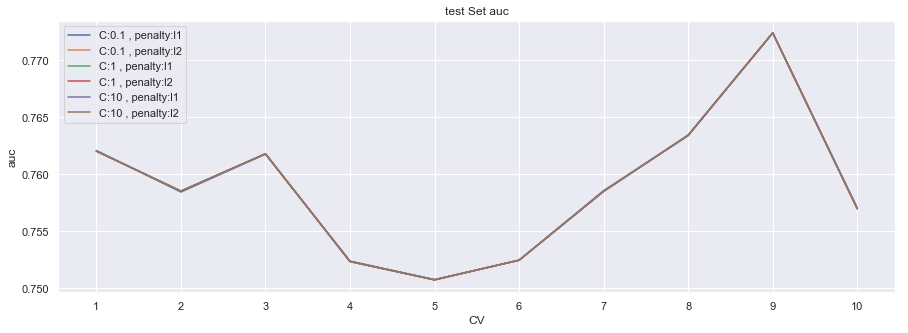

Best Parameters:{'C': 0.1, 'penalty': 'l1'} with score 75.89% based on AUC


In [608]:
plot_logistic_gridsearch("train", "auc", cv)
plot_logistic_gridsearch("test", "auc", cv)
print("Best Parameters:%s with score %s%% based on AUC"%(gsearch.best_params_, str(round(gsearch.best_score_*100,2))))

### Random Forest Classifier
Overall Average Accuracy of Train is above 98%, but Accuracy of Test set is only about 75%. Average Recall of Train set is above 98%, but Recall is only about 70%. In this case, Over-fitting happens in this model.

In [609]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

'''
Train Classifier by using Cross Validation Method
'''
scoring=["accuracy", "recall", "precision"] #Measuring Metrics
cv=10 #Number of Cross Validation Partitions

#Store Train and Test Score
train_accuracy_lst, train_recall_lst, train_precision_lst=[],[],[]
test_accuracy_lst,test_recall_lst, test_precision_lst=[],[],[]

#List to store "Number of Estimator"
n_estimator_lst = [100,200,500,700,1000]
for n_estimator in n_estimator_lst:
    clf= RandomForestClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
    scores=cross_validate(clf, X,y, cv=cv,scoring=scoring, return_train_score=True)
    
    train_precision_lst.append(scores["train_precision"])    
    train_recall_lst.append(scores["train_recall"])
    train_accuracy_lst.append(scores["train_accuracy"])
    
    
    test_precision_lst.append(scores["test_precision"])    
    test_recall_lst.append(scores["test_recall"])
    test_accuracy_lst.append(scores["test_accuracy"])  
    
'''
Store Measurment metrics into DataFrame
'''    
metricDf=pd.DataFrame(list(zip(n_estimator_lst,
                               train_accuracy_lst,train_recall_lst, train_precision_lst,
                               test_accuracy_lst,test_recall_lst, test_precision_lst)), 
                      columns=["n_estimator_lst",
                               "train_accuracy_lst","train_recall_lst", "train_precision_lst",
                               "test_accuracy_lst","test_recall_lst", "test_precision_lst"])    

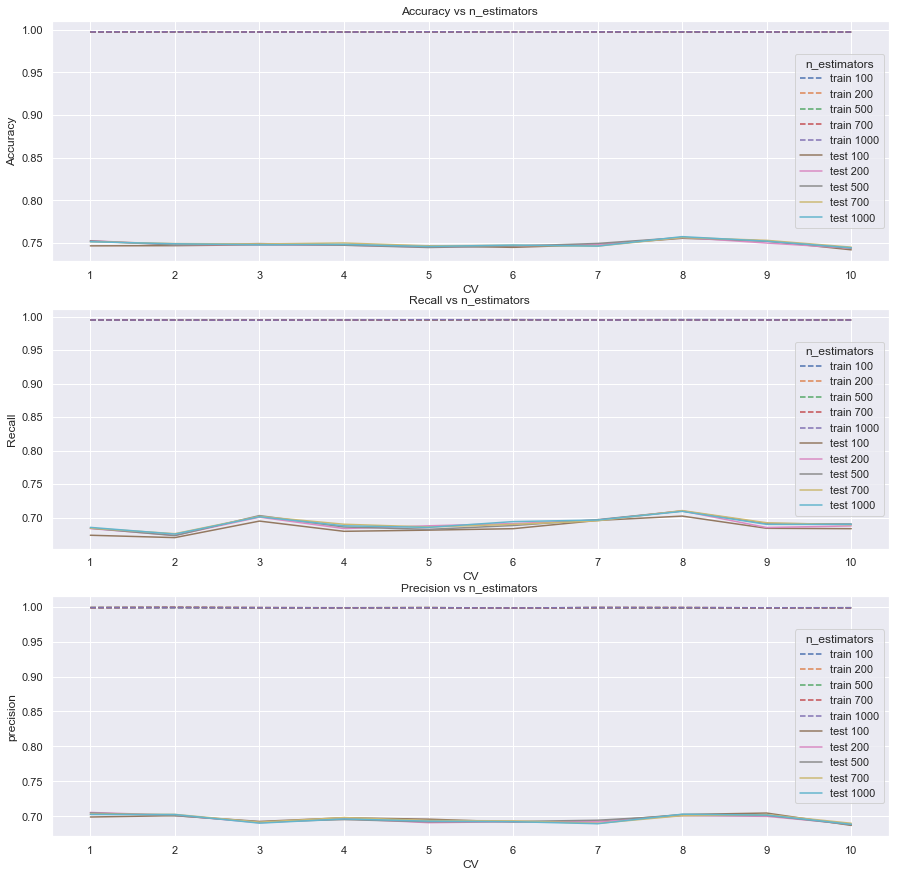

In [610]:
'''
Plot Measurment metrics from the above trained models.
'''
fig=plt.figure(figsize=(15,15))

#Metric 1
ax1=fig.add_subplot(3,1,1)
for i in range(0,metricDf["train_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["train_accuracy_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_accuracy_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Accuracy vs n_estimators ")
plt.ylabel("Accuracy")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

#Metric 2
ax1=fig.add_subplot(3,1,2)
for i in range(0,metricDf["train_recall_lst"].shape[0]):
    ax1.plot(metricDf["train_recall_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_recall_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Recall vs n_estimators ")
plt.ylabel("Recall")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")


#Metric 3
ax1=fig.add_subplot(3,1,3)
for i in range(0,metricDf["train_precision_lst"].shape[0]):
    ax1.plot(metricDf["train_precision_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_precision_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Precision vs n_estimators ")
plt.ylabel("precision")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

plt.show()

In [611]:
def Barplot_avg_metric(x, y, metric):
    fig = plt.figure(figsize=(15,5))
#    ax=fig.add_subplot(1,3,axNo)
    plt.bar(x=x, height=y, width=50)
    plt.ylim(top=max(y)+0.02, bottom=min(y)-0.02)
    plt.xticks(ticks=np.arange(0,1100,100))
    plt.title("%s vs n_estimator" %(metric))
    plt.ylabel("%s" %(metric))
    plt.xlabel("n_estimators")
    plt.show()
    

In [612]:
avg_test_recall_lst, avg_test_accuracy_lst, avg_test_precision_lst=[], [], []

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    avg_test_accuracy_lst.append(np.mean(metricDf["test_accuracy_lst"][i])) 

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    avg_test_recall_lst.append(np.mean(metricDf["test_recall_lst"][i]))

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    avg_test_precision_lst.append(np.mean(metricDf["test_precision_lst"][i])) 

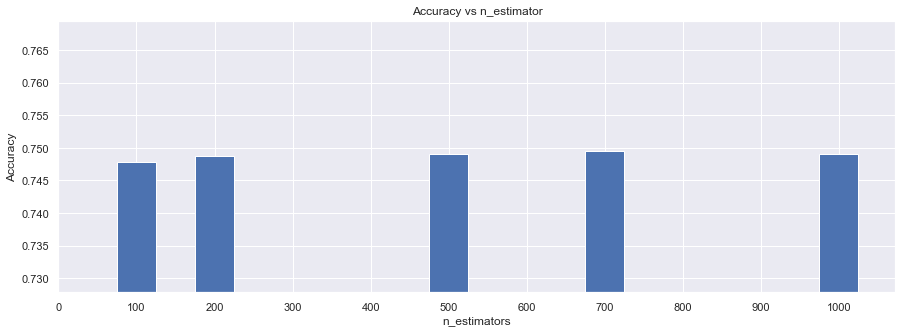

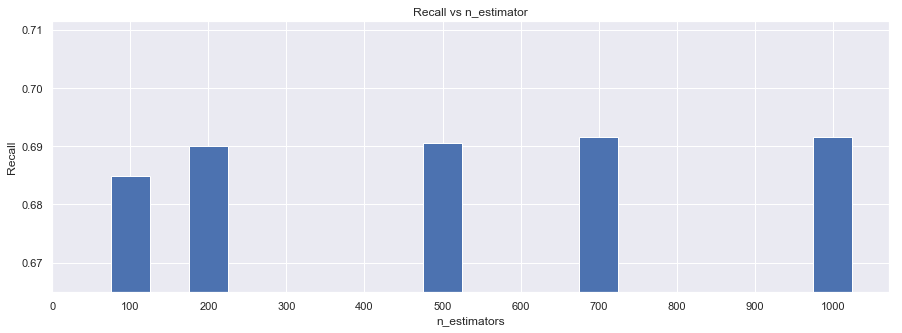

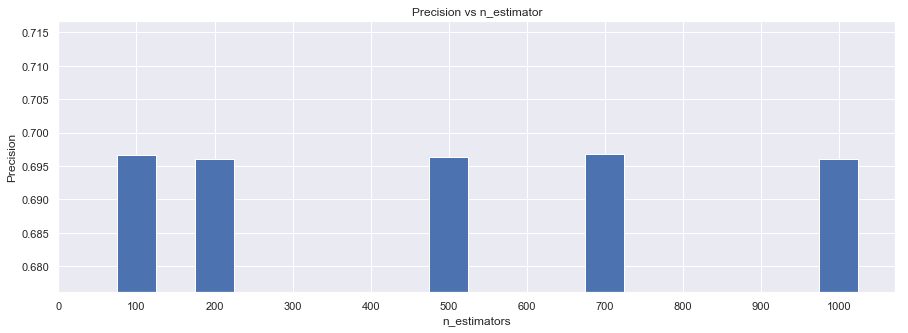

In [613]:
Barplot_avg_metric(n_estimator_lst,avg_test_accuracy_lst, "Accuracy")
Barplot_avg_metric(n_estimator_lst,avg_test_recall_lst, "Recall")
Barplot_avg_metric(n_estimator_lst,avg_test_precision_lst, "Precision")

### Gradient Boosting Classifier
Overall Average Accuracy of Train and Test set align 78-80%; Average Recall of Train and Test set aligns around 70-73%. There is No over-fitting or under-fitting found from this result

In [615]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

'''
Train Classifier by using Cross Validation Method
'''
scoring=["accuracy", "recall", "precision"] #Measuring Metrics
cv=10 #Number of Cross Validation Partitions

#Store Train and Test Score
train_accuracy_lst, train_recall_lst, train_precision_lst=[],[],[]
test_accuracy_lst,test_recall_lst, test_precision_lst=[],[],[]

#List to store "Number of Estimator"
n_estimator_lst = [100,200,500,700,1000]
for n_estimator in n_estimator_lst:
    clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
    scores=cross_validate(clf, X,y, cv=cv,scoring=scoring, return_train_score=True)
    
    train_precision_lst.append(scores["train_precision"])    
    train_recall_lst.append(scores["train_recall"])
    train_accuracy_lst.append(scores["train_accuracy"])
    
    
    test_precision_lst.append(scores["test_precision"])    
    test_recall_lst.append(scores["test_recall"])
    test_accuracy_lst.append(scores["test_accuracy"])  
    
'''
Store Measurment metrics into DataFrame
'''    
metricDf=pd.DataFrame(list(zip(n_estimator_lst,
                               train_accuracy_lst,train_recall_lst, train_precision_lst,
                               test_accuracy_lst,test_recall_lst, test_precision_lst)), 
                      columns=["n_estimator_lst",
                               "train_accuracy_lst","train_recall_lst", "train_precision_lst",
                               "test_accuracy_lst","test_recall_lst", "test_precision_lst"])    

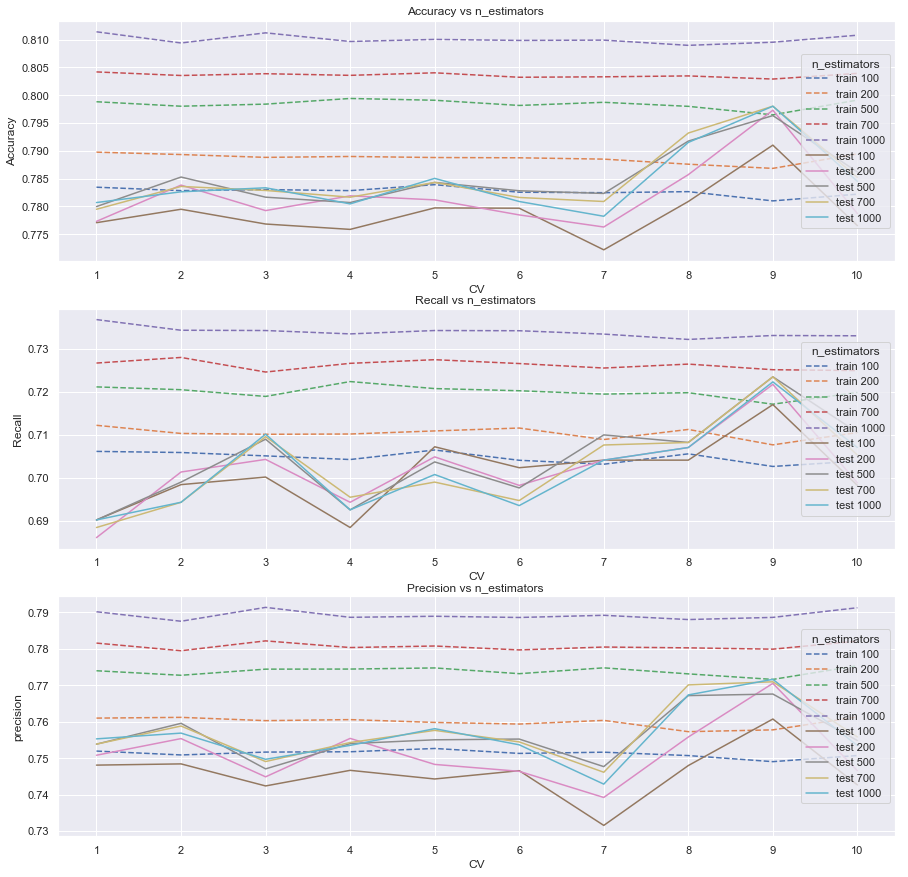

In [616]:
'''
Plot Measurment metrics from the above trained models.
'''
fig=plt.figure(figsize=(15,15))

#Metric 1
ax1=fig.add_subplot(3,1,1)
for i in range(0,metricDf["train_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["train_accuracy_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    ax1.plot(metricDf["test_accuracy_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Accuracy vs n_estimators ")
plt.ylabel("Accuracy")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

#Metric 2
ax1=fig.add_subplot(3,1,2)
for i in range(0,metricDf["train_recall_lst"].shape[0]):
    ax1.plot(metricDf["train_recall_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    ax1.plot(metricDf["test_recall_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Recall vs n_estimators ")
plt.ylabel("Recall")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")


#Metric 3
ax1=fig.add_subplot(3,1,3)
for i in range(0,metricDf["train_precision_lst"].shape[0]):
    ax1.plot(metricDf["train_precision_lst"][i], label="train "+str(n_estimator_lst[i]), linestyle="--")

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    ax1.plot(metricDf["test_precision_lst"][i], label="test "+str(n_estimator_lst[i]))

plt.xticks(ticks=np.arange(0,cv), labels=list(map(str,np.arange(1,cv+1))))
plt.title("Precision vs n_estimators ")
plt.ylabel("precision")
plt.xlabel("CV")
plt.legend(title="n_estimators", loc="right")

plt.show()

In [617]:
def Barplot_avg_metric(x, y, metric):
    fig = plt.figure(figsize=(15,5))
#    ax=fig.add_subplot(1,3,axNo)
    plt.bar(x=x, height=y, width=50)
    plt.ylim(top=max(y)+0.02, bottom=min(y)-0.02)
    plt.xticks(ticks=np.arange(0,1100,100))
    plt.title("%s vs n_estimator" %(metric))
    plt.ylabel("%s" %(metric))
    plt.xlabel("n_estimators")
    plt.show()
    

In [618]:
avg_test_recall_lst, avg_test_accuracy_lst, avg_test_precision_lst=[], [], []

for i in range(0,metricDf["test_accuracy_lst"].shape[0]):
    avg_test_accuracy_lst.append(np.mean(metricDf["test_accuracy_lst"][i])) 

for i in range(0,metricDf["test_recall_lst"].shape[0]):
    avg_test_recall_lst.append(np.mean(metricDf["test_recall_lst"][i]))

for i in range(0,metricDf["test_precision_lst"].shape[0]):
    avg_test_precision_lst.append(np.mean(metricDf["test_precision_lst"][i])) 

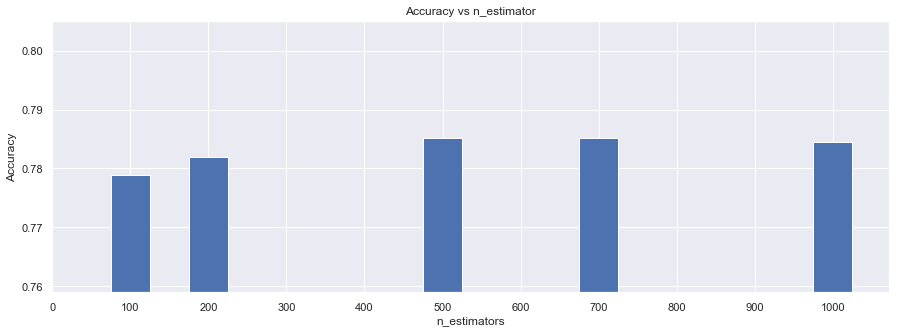

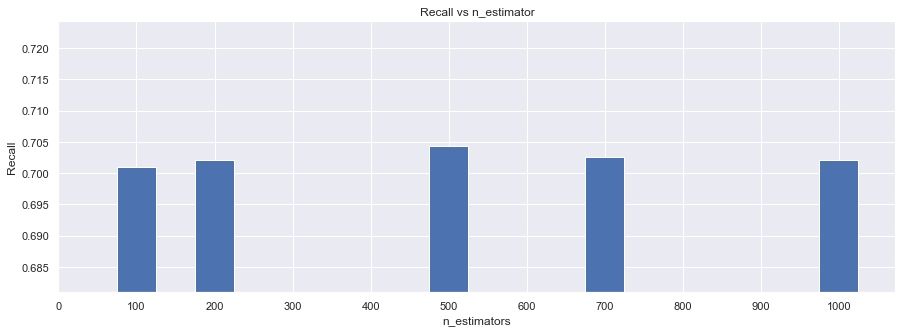

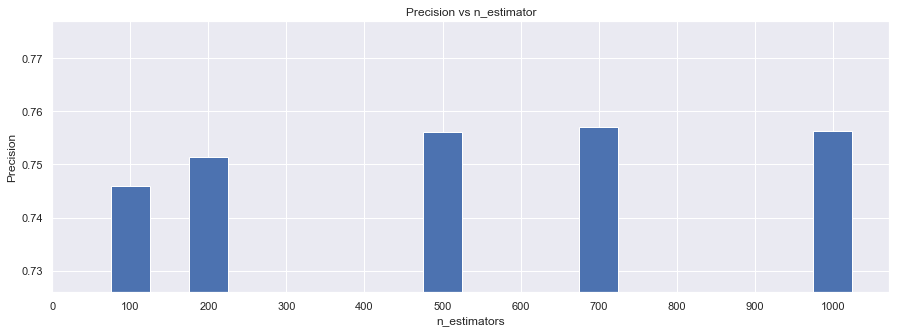

In [619]:
Barplot_avg_metric(n_estimator_lst,avg_test_accuracy_lst, "Accuracy")
Barplot_avg_metric(n_estimator_lst,avg_test_recall_lst, "Recall")
Barplot_avg_metric(n_estimator_lst,avg_test_precision_lst, "Precision")

## Models Comparison (t-test) 
Summary: 
In order to pick out the best classifier, t-tests were performed to verify the classification results (Discuss below). In addition, Receiver Operating Characteristics graph will be constructed to verify the TPR values. For the purpose searching a reliable and stable (<font, color="blue">i.e. No Over-fitting or Under-fitting</font>) model, G.B. and L.R. will be selected for further verify by t-test.

The t-test result indicates that performace of all three classifiers are distinctively different based on the Hypothesis as shown below. The P-value is smaller than t-value for all cases which means that the Null hypothesis shall be rejected, the alt. hypothesis shall be taken. With this result, the chart below shows that the Gradient Boosting generates the highest Accuacy and Recall values, so that we could conclude that G.B. model has the highest generalized capability (i.e. Accuracy=78%, Recall=69%) to forecast the driver activity. Furthermore, The ROC-AUC graph also proves that the the GB model generates average 85% AUC (i.e. Area under Curve) values with 10 Cross Validation. So that this result would be able to support our goal of this project to forecast the driver activity (i.e. label=1, Active users in the last month)

 - *Null: Performance of Classifers are the SAME*
 - *Alt: *Null: Performance of Classifers are NOT the SAME*


In [657]:
'''t-test to compare model Accuracy'''    
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split
import time

#scoring=["accuracy", "recall", "precision"]
sampling_times=50
n_estimator=1000
cv=5
'''Random Sampling Accuracy for Model 1'''
clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
acc_gb_lst, recall_gb_lst=[],[]
for i in range(0,sampling_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    acc_gb_lst.append(accuracy_score(y_test, y_pred))
    recall_gb_lst.append(recall_score(y_test, y_pred))

In [549]:
'''Random Sampling Accuracy for Model 2'''
clf= RandomForestClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
acc_rf_lst, recall_rf_lst=[],[]
for i in range(0,sampling_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    acc_rf_lst.append(accuracy_score(y_test, y_pred))
    recall_rf_lst.append(recall_score(y_test, y_pred))

In [663]:
'''Random Sampling Accuracy for Model 3'''
clf= LogisticRegression(C=0.1,penalty="l1",random_state=1)
acc_lr_lst, recall_lr_lst=[],[]
for i in range(0,sampling_times):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    acc_lr_lst.append(accuracy_score(y_test, y_pred))
    recall_lr_lst.append(recall_score(y_test, y_pred))

## t-tesst Accuracy and Recall Comparison

#### Accuracy

In [665]:
# Use scipy.stats.ttest_ind.
t, p = ttest_ind(acc_gb_lst, acc_lr_lst, equal_var=False)
print("Model Gradient Boosting Average Accuracy:", np.mean(acc_gb_lst))
print("Model Logistic Regression Average Accuracy:", np.mean(acc_lr_lst))
print("ttest_ind:            t = %g  p = %g" % (t, p))  

Model Gradient Boosting Average Accuracy: 0.7825838999780653
Model Logistic Regression Average Accuracy: 0.7048080719456021
ttest_ind:            t = 137.375  p = 5.20189e-112


#### Recall

In [664]:
# Use scipy.stats.ttest_ind.
t, p = ttest_ind(recall_gb_lst, recall_lr_lst, equal_var=False)
print("Model Gradient Boosting Average Recall:", np.mean(recall_gb_lst))
print("Model Logistic Regression Average Recall:", np.mean(recall_lr_lst))
print("ttest_ind:            t = %g  p = %g" % (t, p))  

Model Gradient Boosting Average Recall: 0.6980722497424133
Model Logistic Regression Average Recall: 0.5428401325229296
ttest_ind:            t = 121.585  p = 2.69864e-104


Result Table


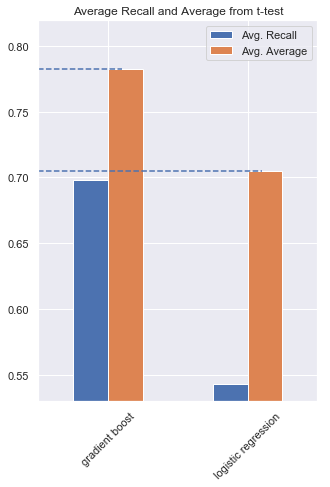

In [666]:
a1=np.array(list(zip((np.mean(recall_gb_lst), np.mean( recall_lr_lst)))))
a2=np.array(list(zip((np.mean(acc_gb_lst), np.mean( acc_lr_lst)))))
print("Result Table" )
ttestDf=pd.DataFrame(np.hstack((a1,a2)), columns=["Avg. Recall", "Avg. Average"], index=["gradient boost", "logistic regression"])


ttestDf.plot.bar(figsize=(5,7))
plt.ylim(top=max(acc_gb_lst)+0.03, bottom=min(recall_lr_lst))
plt.title("Average Recall and Average from t-test")
plt.xticks(rotation=45)
plt.axhline(y=np.mean(acc_gb_lst), linestyle="--", xmax=0.3)
plt.axhline(y=np.mean(acc_lr_lst), linestyle="--", xmax=0.8)
plt.show()

### ROC - AUC on the best model

In [ ]:
'''
Reload the Dataset (X and y)
'''
with open("./data/XnormalizedDataPickle", "rb") as file:
    X = pickle.load(file)
    
with open("./data/ynormalizedDataPickle", "rb") as file:
    y = pickle.load(file)      
    
#print(X.shape, y.shape)
#print(X.head(3), y.head(3))  

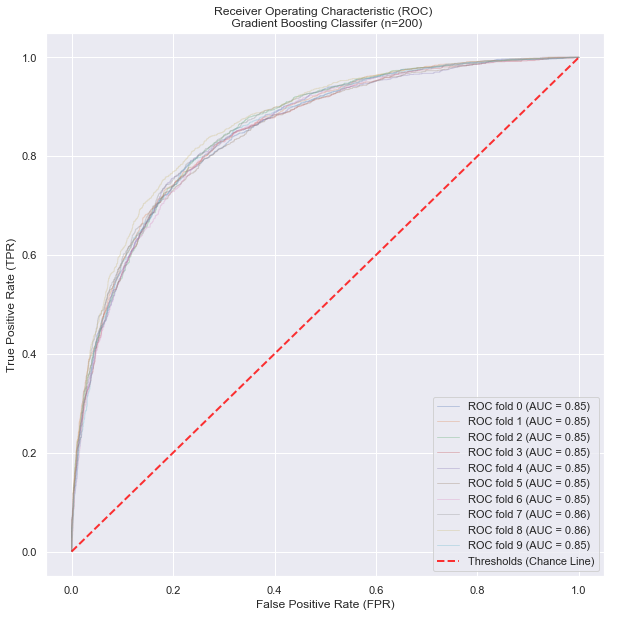

In [637]:
'''
Compute ROC and AUC based on the best model determined from above
'''
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
cv = StratifiedKFold(n_splits=10)
#classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)

#tprs = []
#aucs = []
#mean_fpr = np.linspace(0, 1, 100)

fig=plt.figure(figsize=(10,10))

for i,(train, test) in enumerate(cv.split(X, y)):
    #print(train)
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    
    # Compute ROC curve (TPR, FPR based on thresholds)
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    # Compute area the curve
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red',label='Thresholds (Chance Line)', alpha=.8)
plt.title("Receiver Operating Characteristic (ROC) \n Gradient Boosting Classifer (n=200)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()    
plt.show()

### Summary / Feature importance / Recommendation
The following shows the proportion of importances of features for our best model (i.e. Gradient Boosting Classifier). The top four features (i.e. weekday_pct, avg_dist, surge_pct, avg_rating_by_driver) takes more than 50% of contribution to the model. Comparing this result with the boxplots above, we could have more confidence to tell how the two groups of labels being classified by these features. 

There are some recommendations which might be help for longterm rider retention:

 - weekday_pct: The result shows that this feature is one of the important features to the model. So that Ultimate should take a closer look to drivers' habit to drive in weekdays. The analysis above shows that the more the driver drives in weekdays, the less chance the driver would stay with Ultimate.

 - avg_dist: Since this feature is one of main feature contributes to the model, so that Ultimate should pay more attention to the distance the drivers have done after the first month signed up. Based on the boxplot, the smaller range of distance the drivers drove, the more chance they would retain to use Ultimate service
 
 - surge_pct: The active driver tends to be use Ultimate with higher surge percent. In other words, Ultmate could offer more incentives to drivers if they intend to work in higher surge demand period.
 
 - avg_rating_by_driver: The active target group 1 driver has the wider range of rating (i.e. 4-5) by driver, Ultimate could take this as a reference to communicate more with these driver in order to retain these drivers.


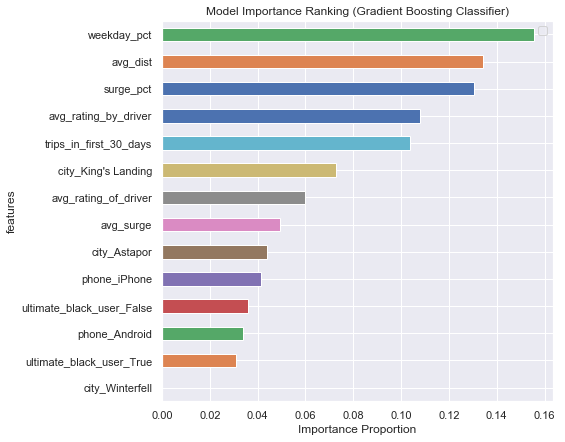

In [656]:
clf= GradientBoostingClassifier(n_estimators= n_estimator, verbose=0, random_state=1)
clf.fit(X_train, y_train)

importanceDf=pd.DataFrame(list(zip(cols, importances)), columns=["features", "importances"]).sort_values(by=["importances"], 
                                                                                           ascending=True)
importanceDf.plot.barh(x="features", y="importances", figsize=(7,7))
plt.xlabel("Importance Proportion")
plt.title("Model Importance Ranking (Gradient Boosting Classifier)")
plt.legend([])
plt.show()
